# Jitter Outline

1. Create stylistic space with two distinct styles, and some ambiguous points.
2. Re-define every embedding as the average of the embeddings that are similar to it.
3. Re-embed and see if it worked.


NOTES:
- The jittering idea did not work, we instead settle for interpolating.

In [2]:
import math
import os
from typing import List, Union

import numpy as np
import umap
import umap.plot
import torch
import torch.nn.functional as F
from sentence_transformers.util import cos_sim
from transformers import AutoModel, AutoTokenizer

/home/riverasoto1/miniforge3/envs/changepoint/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/riverasoto1/miniforge3/envs/changepoint/lib/python3.11/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/riverasoto1/miniforge3/envs/changepoint/lib/python3.11/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/h

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
LUAR_id = "/data1/yubnub/pretrained_weights/LUAR/LUAR-IUR"
model = AutoModel.from_pretrained(LUAR_id, trust_remote_code=True)
model.eval()
model.to(device)
tokenizer = AutoTokenizer.from_pretrained(LUAR_id)

Some weights of the model checkpoint at sentence-transformers/paraphrase-distilroberta-base-v1 were not used when initializing RobertaModel: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
def get_uar_embedding(sample: Union[List[str], str], model, tokenizer, device):
    """Returns a **single** UAR embedding, either for a single sample or a list of samples.
    """
    if not isinstance(sample, list):
        sample = [sample]

    all_input_ids = []
    all_attention_masks = []
    
    for paragraph in sample:
        tok = tokenizer(
            paragraph,
            truncation=False,
            padding=True,
            return_tensors="pt"
        )

        # UAR's backbone can handle up to 512 tokens
        # Here we're padding the sample to the nearest multiple of 512:
        _, NT = tok["input_ids"].size()
        nearest = 512 * int(math.ceil(NT / 512))
        tok["input_ids"] = F.pad(tok["input_ids"], (1, nearest - NT - 1), value=tokenizer.pad_token_id)
        tok["attention_mask"] = F.pad(tok["attention_mask"], (1, nearest - NT - 1), value=0)

        # Reshape into (batch_size=1, history_size=N, num_tokens=512)
        tok["input_ids"] = tok["input_ids"].reshape(1, -1, 512).to(device)
        tok["attention_mask"] = tok["attention_mask"].reshape(1, -1, 512).to(device)

        all_input_ids.append(tok["input_ids"])
        all_attention_masks.append(tok["attention_mask"])
        
    tok = {
        "input_ids": torch.cat(all_input_ids, dim=1),
        "attention_mask": torch.cat(all_attention_masks, dim=1)
    }
    with torch.inference_mode():
        out = model(**tok)
        out = F.normalize(out, p=2.0)
    return out


In [6]:
import file_utils as fu
samples = fu.read_PAN_dataset(fu.PAN23_validation_paths["hard"])

100%|██████████| 900/900 [00:00<00:00, 1491.50it/s]


In [7]:
%load_ext autoreload
%autoreload 2

In [22]:
from tqdm.auto import tqdm
from sklearn.cluster import SpectralClustering
from sklearn.metrics import f1_score
from itertools import chain
from collections import Counter
from sklearn.cluster import HDBSCAN, KMeans, SpectralClustering
from sentence_transformers.util import cos_sim
import search_utils as su
from sklearn.metrics import silhouette_score
import sklearn.metrics as smetrics

In [9]:
def get_changepoints(
    author_partition: List[int]
):
    """Returns a list of 1s and 0s, where 1 indicates a change in the author partition.
    """
    changes = []
    for i in range(1, len(author_partition)):
        if author_partition[i] != author_partition[i-1]:
            changes.append(1)
        else:
            changes.append(0)
    return changes


In [10]:
def get_author_partition(
    changepoints: List[int]
):
    author_partition = [0]
    author_id = 0
    for changepoint in changepoints:
        if changepoint > 0:
            author_id += 1
        author_partition.append(author_id)
    return author_partition

In [11]:
def most_common_changepoint(changepoints_to_counts, author_partitions, embeddings, texts):
    return max(changepoints_to_counts.items(), key=lambda x: x[1])[0]

In [12]:
def get_split_indices(author_partition):
    indices_or_sections = []
    author_id = author_partition[0]
    for i in range(1, len(author_partition)):
        if author_partition[i] != author_id:
            indices_or_sections.append(i)
            author_id = author_partition[i]
    return indices_or_sections

In [13]:
def highest_adjcacent_score(changepoints_to_counts, author_partitions, embeddings, texts):
    highest = 0
    best = None
    for author_partition in author_partitions:        
        adjacent_distance = su.get_proposal_score(texts, author_partition, model, tokenizer, device, "uar")
            
        if adjacent_distance > highest:
            highest = adjacent_distance
            best = get_changepoints(author_partition)
            
    return best
        

In [14]:
def weighted_highest_adjcacent_score(changepoints_to_counts, author_partitions, embeddings, texts):
    highest = 0
    best = None
    for author_partition in author_partitions:        
        adjacent_distance = su.get_proposal_score(texts, author_partition, model, tokenizer, device, "uar")
        weight = changepoints_to_counts[tuple(get_changepoints(author_partition))] / 200
        adjacent_distance *= weight
            
        if adjacent_distance > highest:
            highest = adjacent_distance
            best = get_changepoints(author_partition)
            
    return best

In [121]:
def adjacent_or_most_common(changepoints_to_counts, changepoints_to_partitions, embeddings, texts):
    if len(changepoints_to_counts) == 1:
        return list(changepoints_to_counts.keys())[0]
    
    most_common = changepoints_to_counts.most_common(1)[0][0]
    second_most_common = changepoints_to_counts.most_common(2)[1][0]

    score_most_common = su.get_proposal_score(texts, changepoints_to_partitions[most_common][0], model, tokenizer, device, "uar")
    score_second_most_common = su.get_proposal_score(texts, changepoints_to_partitions[second_most_common][0], model, tokenizer, device, "uar")

    # print(most_common, second_most_common, score_most_common, score_second_most_common)
    if score_second_most_common > score_most_common:
        return second_most_common
    else:
        return most_common

In [16]:
def inter_and_intra(changepoints_to_counts, changepoints_to_partitions, embeddings, texts):
    highest = 0
    best = None
    for changepoint, partitions in changepoints_to_partitions.items():
        author_partition = partitions[0]
        score = su.get_proposal_score_by_intra_and_inter(texts, author_partition, model, tokenizer, device, "uar")
        if score > highest:
            highest = score
            best = changepoint
            
    return best

In [17]:
def get_ss_scores(changepoints_to_counts, changepoints_to_partitions, embeddings, texts):
    highest = 0
    best = None
    for changepoint, partitions in changepoints_to_partitions.items():
        author_partition = partitions[0]
        score = silhouette_score(embeddings, author_partition)
        if score > highest:
            highest = score
            best = changepoint
    return best

In [38]:
def get_calinski_harabasz_scores(changepoints_to_counts, changepoints_to_partitions, embeddings, texts):
    highest = 0
    best = None
    for changepoint, partitions in changepoints_to_partitions.items():
        author_partition = partitions[0]
        score = smetrics.calinski_harabasz_score(embeddings, author_partition)
        if score > highest:
            highest = score
            best = changepoint
    return best

In [30]:
def get_davies_bouldin_scores(changepoints_to_counts, changepoints_to_partitions, embeddings, texts):
    lowest = 999999999
    best = None
    for changepoint, partitions in changepoints_to_partitions.items():
        author_partition = partitions[0]
        score = smetrics.davies_bouldin_score(embeddings, author_partition)
        if score < lowest:
            lowest = score
            best = changepoint
    return best

In [152]:
oracle = []
predictions = []
ground_truth = []

strategy_fn = get_ss_scores

# for test_sample in tqdm(samples):
for test_sample in tqdm(samples[:900]):
    text = test_sample["text"]
    truth = test_sample["changes"]
    
    embeddings = [get_uar_embedding(sample, model, tokenizer, device) for sample in text]
    embeddings = torch.cat(embeddings, dim=0)
    embeddings = interpolate(embeddings, 0.9)
    embeddings = embeddings.cpu().detach().numpy()
    embeddings_clone = embeddings.copy()
    
    # Calculate the Possible ChangePoints using a Clustering Algorithm:
    possible_partitions = []
    for _ in range(200):
        perm = np.random.permutation(len(embeddings))
        embeddings = embeddings_clone
        cluster_alg = KMeans(n_clusters=test_sample["authors"], init="k-means++").fit(embeddings)
        # cluster_alg = SpectralClustering(n_clusters=test_sample["authors"], affinity="cosine").fit(embeddings)
        possible_partitions.append(cluster_alg.labels_)

    changepoints = [get_changepoints(partition) for partition in possible_partitions]
    changepoints_to_counts = Counter([tuple(changepoint) for changepoint in changepoints])

    changepoints_to_partitions = {}
    for partition, changepoint in zip(possible_partitions, changepoints):
        if tuple(changepoint) not in changepoints_to_partitions:
            changepoints_to_partitions[tuple(changepoint)] = []
        changepoints_to_partitions[tuple(changepoint)].append(partition)    

    unique_partitions = list(set([tuple(partition) for partition in possible_partitions]))
    
    # Use some measure to determine the most likely changepoint:
    try:
        strategy_pick = strategy_fn(changepoints_to_counts, changepoints_to_partitions, embeddings, test_sample["text"])
    except:
        continue

    ground_truth.append(truth)
    predictions.append(strategy_pick)
    
    print(strategy_pick, truth)
    
    # Store the highest perforaming changepoint (Oracle):
    best_changepoint = [
        (changepoint, f1_score(truth, changepoint, average="macro", labels=[0, 1], zero_division=0.0))
        for changepoint in changepoints_to_counts.keys()
    ]
    best_changepoint = max(best_changepoint, key=lambda x: x[1])
    oracle.append(best_changepoint[0])
    
predictions = list(chain.from_iterable(predictions))
ground_truth = list(chain.from_iterable(ground_truth))
print("Score: ", f1_score(ground_truth, predictions, average="macro", labels=[0, 1], zero_division=0.0))

oracle = list(chain.from_iterable(oracle))
print("Oracle Score: ", f1_score(ground_truth, oracle, average="macro", labels=[0, 1], zero_division=0.0))

  0%|          | 1/900 [00:00<06:23,  2.34it/s]

(1, 1, 1, 1) [0, 1, 1, 1]


  0%|          | 2/900 [00:00<05:37,  2.66it/s]

(1, 0, 1, 0, 0) [0, 0, 0, 1, 0]


  0%|          | 3/900 [00:01<06:03,  2.47it/s]

(1, 1, 0, 1, 1) [1, 0, 1, 1, 1]


  0%|          | 4/900 [00:01<06:10,  2.42it/s]

(1, 0, 1, 1) [1, 0, 1, 1]


  1%|          | 5/900 [00:01<05:44,  2.59it/s]

(0, 1, 0, 0, 0) [0, 1, 0, 0, 0]


  1%|          | 6/900 [00:02<05:26,  2.74it/s]

(0, 0, 0, 1, 0) [0, 0, 0, 1, 0]


  1%|          | 7/900 [00:02<05:12,  2.85it/s]

(0, 1, 0, 0) [0, 1, 0, 0]


  1%|          | 8/900 [00:02<05:03,  2.94it/s]

(1, 1, 1, 0) [1, 0, 0, 0]


  1%|          | 9/900 [00:03<04:58,  2.99it/s]

(1, 0, 0, 0) [1, 0, 0, 0]


  1%|          | 10/900 [00:03<05:09,  2.87it/s]

(1, 0, 1, 1) [1, 0, 0, 1]


  1%|          | 11/900 [00:03<05:05,  2.91it/s]

(0, 0, 0, 1, 0) [1, 0, 0, 0, 0]


  1%|▏         | 12/900 [00:04<04:55,  3.00it/s]

(0, 1, 0) [0, 1, 0]


  1%|▏         | 13/900 [00:04<04:43,  3.13it/s]

(0, 1) [0, 1]


  2%|▏         | 14/900 [00:04<04:57,  2.98it/s]

(1, 0, 0, 1) [1, 0, 1, 0]


  2%|▏         | 15/900 [00:05<04:49,  3.06it/s]

(1, 0, 0) [1, 0, 0]


  2%|▏         | 16/900 [00:05<04:57,  2.97it/s]

(0, 1, 1) [1, 0, 1]


  2%|▏         | 17/900 [00:05<04:52,  3.02it/s]

(0, 0, 1, 1) [1, 0, 0, 0]


  2%|▏         | 18/900 [00:06<04:49,  3.04it/s]

(0, 0, 0, 1) [0, 0, 0, 1]


  2%|▏         | 19/900 [00:06<04:51,  3.02it/s]

(0, 1, 0, 0, 0) [0, 1, 0, 0, 0]


  2%|▏         | 20/900 [00:06<05:07,  2.86it/s]

(0, 0, 1, 1, 0) [1, 0, 0, 0, 1]


  2%|▏         | 21/900 [00:07<05:42,  2.57it/s]

(0, 1, 1, 0, 0, 1, 1) [0, 1, 0, 1, 0, 0, 1]


  2%|▏         | 22/900 [00:07<05:39,  2.59it/s]

(0, 1, 0, 1) [0, 0, 1, 1]


  3%|▎         | 23/900 [00:08<05:17,  2.76it/s]

(0, 1, 0) [1, 0, 0]


  3%|▎         | 24/900 [00:08<05:43,  2.55it/s]

(1, 1, 0, 1, 0, 0) [0, 0, 1, 0, 1, 1]


  3%|▎         | 25/900 [00:08<05:39,  2.58it/s]

(1, 0, 1, 0) [1, 1, 0, 0]


  3%|▎         | 26/900 [00:09<05:51,  2.49it/s]

(1, 1, 1, 1, 1) [0, 1, 0, 1, 1]


  3%|▎         | 29/900 [00:10<05:28,  2.65it/s]

(1, 1, 0, 1) [0, 1, 0, 0]


  3%|▎         | 30/900 [00:10<05:24,  2.68it/s]

(1, 1, 1) [0, 1, 1]


  3%|▎         | 31/900 [00:11<05:14,  2.77it/s]

(0, 0, 1, 0, 1) [0, 1, 0, 0, 0]


  4%|▎         | 32/900 [00:11<05:31,  2.62it/s]

(1, 0, 1, 1) [1, 0, 1, 1]


  4%|▎         | 33/900 [00:11<05:11,  2.78it/s]

(0, 1, 0) [0, 1, 0]


  4%|▍         | 34/900 [00:12<05:04,  2.84it/s]

(0, 1, 0, 0, 0) [0, 1, 0, 0, 0]


  4%|▍         | 36/900 [00:13<05:20,  2.70it/s]

(1, 1, 1, 1) [0, 0, 1, 1]


  4%|▍         | 37/900 [00:13<05:03,  2.84it/s]

(1, 0, 1) [0, 0, 1]


  4%|▍         | 38/900 [00:13<05:26,  2.64it/s]

(1, 1, 0, 0, 1) [0, 1, 0, 1, 1]


  4%|▍         | 39/900 [00:14<05:26,  2.64it/s]

(0, 1, 1, 0) [1, 1, 0, 0]


  4%|▍         | 40/900 [00:14<05:49,  2.46it/s]

(1, 0, 1, 0, 0, 1, 1) [1, 1, 0, 0, 0, 1, 1]


  5%|▍         | 41/900 [00:14<05:19,  2.69it/s]

(0, 1) [0, 1]


  5%|▍         | 42/900 [00:15<05:05,  2.81it/s]

(0, 1, 0, 1) [1, 0, 0, 0]


  5%|▍         | 43/900 [00:15<05:09,  2.77it/s]

(0, 1, 1, 0) [0, 1, 1, 0]


  5%|▍         | 44/900 [00:16<05:18,  2.69it/s]

(0, 0, 1, 0, 1) [0, 0, 0, 1, 1]


  5%|▌         | 45/900 [00:16<05:39,  2.52it/s]

(0, 0, 1, 1, 1, 1) [0, 0, 1, 1, 1, 1]


  5%|▌         | 46/900 [00:16<05:16,  2.70it/s]

(1, 0, 1) [0, 0, 1]


  5%|▌         | 47/900 [00:17<05:08,  2.77it/s]

(0, 1, 0, 1, 0) [0, 1, 0, 1, 0]


  5%|▌         | 48/900 [00:17<04:54,  2.89it/s]

(0, 1, 0) [0, 1, 0]


  5%|▌         | 49/900 [00:17<05:02,  2.82it/s]

(1, 0, 0, 1) [0, 1, 0, 1]


  6%|▌         | 50/900 [00:18<04:50,  2.93it/s]

(0, 1, 0) [0, 0, 1]


  6%|▌         | 51/900 [00:18<04:41,  3.02it/s]

(1, 0, 1) [0, 0, 1]


  6%|▌         | 52/900 [00:18<04:38,  3.04it/s]

(0, 0, 1, 0) [0, 0, 0, 1]


  6%|▌         | 53/900 [00:19<04:33,  3.09it/s]

(1, 0, 1) [0, 0, 1]


  6%|▌         | 54/900 [00:19<04:42,  2.99it/s]

(1, 1, 1) [1, 1, 1]


  6%|▌         | 55/900 [00:19<04:51,  2.90it/s]

(0, 1, 1, 1) [0, 1, 0, 1]


  6%|▌         | 56/900 [00:20<04:58,  2.83it/s]

(1, 1, 0, 0) [0, 1, 0, 1]


  6%|▋         | 57/900 [00:20<05:16,  2.67it/s]

(1, 1, 1, 1) [1, 1, 1, 0]


  6%|▋         | 58/900 [00:21<05:32,  2.54it/s]

(1, 0, 0, 1, 1) [0, 1, 1, 1, 1]


  7%|▋         | 59/900 [00:21<05:47,  2.42it/s]

(1, 0, 0, 1, 1, 1) [1, 0, 0, 0, 1, 1]


  7%|▋         | 60/900 [00:21<05:12,  2.69it/s]

(0, 1) [0, 1]


  7%|▋         | 61/900 [00:22<05:13,  2.68it/s]

(1, 1, 1, 1) [1, 1, 0, 1]


  7%|▋         | 62/900 [00:22<05:13,  2.67it/s]

(0, 1, 1, 1) [1, 0, 0, 1]


  7%|▋         | 63/900 [00:22<05:26,  2.56it/s]

(1, 0, 1, 1) [1, 1, 0, 1]


  7%|▋         | 64/900 [00:23<05:47,  2.40it/s]

(0, 1, 0, 1, 0, 1, 0) [0, 0, 1, 1, 0, 1, 0]


  7%|▋         | 65/900 [00:23<05:40,  2.45it/s]

(0, 1, 1, 1, 1) [1, 1, 0, 0, 0]


  7%|▋         | 66/900 [00:24<05:17,  2.63it/s]

(0, 1, 1, 0) [0, 1, 1, 0]


  7%|▋         | 67/900 [00:24<05:12,  2.67it/s]

(1, 1, 0) [1, 1, 0]


  8%|▊         | 68/900 [00:24<05:05,  2.72it/s]

(1, 1, 0, 0, 0, 0) [0, 0, 1, 0, 0, 0]


  8%|▊         | 70/900 [00:25<05:02,  2.75it/s]

(0, 0, 1, 1) [1, 0, 0, 1]


  8%|▊         | 71/900 [00:25<05:05,  2.72it/s]

(0, 1, 1, 0) [0, 1, 1, 0]


  8%|▊         | 72/900 [00:26<05:11,  2.66it/s]

(0, 1, 0, 0, 1) [0, 0, 1, 0, 1]


  8%|▊         | 73/900 [00:26<04:53,  2.82it/s]

(1, 0, 0) [0, 1, 0]


  8%|▊         | 74/900 [00:27<05:02,  2.73it/s]

(0, 1, 0, 1, 0) [0, 0, 1, 1, 0]


  8%|▊         | 75/900 [00:27<04:41,  2.93it/s]

(1, 1) [0, 1]


  8%|▊         | 76/900 [00:27<04:59,  2.75it/s]

(1, 0, 1, 0, 1, 0, 1) [0, 1, 1, 0, 0, 0, 0]


  9%|▊         | 77/900 [00:28<05:23,  2.54it/s]

(1, 0, 0, 1, 1, 0) [1, 1, 0, 1, 0, 0]


  9%|▊         | 78/900 [00:28<05:30,  2.49it/s]

(0, 1, 1, 0, 0, 0, 1) [0, 0, 1, 0, 0, 0, 1]


  9%|▉         | 79/900 [00:28<05:06,  2.68it/s]

(0, 1, 0) [0, 1, 0]


  9%|▉         | 80/900 [00:29<04:49,  2.83it/s]

(1, 0, 0) [1, 0, 0]


  9%|▉         | 81/900 [00:29<05:06,  2.67it/s]

(1, 1, 1, 0) [0, 1, 1, 1]


  9%|▉         | 82/900 [00:30<04:53,  2.79it/s]

(1, 0, 0, 0) [1, 0, 0, 0]


  9%|▉         | 83/900 [00:30<05:06,  2.66it/s]

(1, 0, 1, 0, 0, 0) [0, 1, 0, 0, 0, 1]


  9%|▉         | 84/900 [00:30<05:06,  2.66it/s]

(1, 1, 1, 0) [0, 0, 1, 1]


  9%|▉         | 85/900 [00:31<05:21,  2.53it/s]

(1, 0, 0, 1, 1) [0, 1, 0, 1, 1]


 10%|▉         | 86/900 [00:31<05:13,  2.60it/s]

(0, 1, 1) [0, 1, 1]


 10%|▉         | 87/900 [00:31<05:07,  2.64it/s]

(1, 1, 0) [1, 0, 1]


 10%|▉         | 88/900 [00:32<04:44,  2.85it/s]

(1, 0) [1, 0]


 10%|█         | 90/900 [00:33<04:59,  2.71it/s]

(1, 1, 0, 0) [1, 0, 0, 1]


 10%|█         | 91/900 [00:33<04:44,  2.84it/s]

(0, 1, 0) [1, 0, 0]


 10%|█         | 92/900 [00:33<04:56,  2.73it/s]

(0, 1, 1, 0, 1, 0) [0, 1, 0, 0, 1, 0]


 10%|█         | 93/900 [00:34<05:14,  2.56it/s]

(0, 1, 1, 1, 1) [0, 1, 1, 1, 0]


 10%|█         | 94/900 [00:34<05:27,  2.46it/s]

(0, 1, 1, 1, 0) [0, 1, 1, 1, 0]


 11%|█         | 95/900 [00:35<05:36,  2.39it/s]

(1, 1, 0, 1, 1) [1, 0, 1, 1, 0]


 11%|█         | 96/900 [00:35<05:41,  2.35it/s]

(0, 1, 1, 1, 1) [0, 1, 1, 1, 1]


 11%|█         | 97/900 [00:35<05:12,  2.57it/s]

(1, 0, 0) [1, 0, 0]


 11%|█         | 98/900 [00:36<05:04,  2.64it/s]

(0, 0, 1, 0, 0, 0, 0) [0, 0, 1, 0, 0, 0, 0]


 11%|█         | 99/900 [00:36<04:42,  2.84it/s]

(1, 0) [1, 0]


 11%|█         | 100/900 [00:36<04:22,  3.04it/s]

(1, 0) [1, 0]


 11%|█         | 101/900 [00:37<04:54,  2.72it/s]

(1, 0, 1, 0, 0, 1) [1, 0, 1, 1, 0, 1]


 11%|█▏        | 102/900 [00:37<05:03,  2.63it/s]

(1, 1, 0, 0, 1, 1) [0, 0, 0, 0, 1, 1]


 11%|█▏        | 103/900 [00:38<05:07,  2.59it/s]

(0, 1, 0, 0, 1, 0) [0, 1, 0, 0, 1, 0]


 12%|█▏        | 104/900 [00:38<05:07,  2.58it/s]

(0, 1, 1, 1, 1) [1, 1, 0, 0, 0]


 12%|█▏        | 105/900 [00:38<05:07,  2.59it/s]

(1, 0, 1, 1, 0) [0, 0, 0, 1, 1]


 12%|█▏        | 106/900 [00:39<05:06,  2.59it/s]

(0, 1, 1, 1, 0) [1, 1, 0, 1, 1]


 12%|█▏        | 107/900 [00:39<05:09,  2.56it/s]

(1, 1, 0, 0, 0) [0, 1, 1, 1, 1]


 12%|█▏        | 108/900 [00:40<05:17,  2.49it/s]

(1, 1, 1, 0) [1, 1, 1, 0]


 12%|█▏        | 109/900 [00:40<05:10,  2.55it/s]

(1, 0, 0, 1) [1, 0, 0, 1]


 12%|█▏        | 110/900 [00:40<05:06,  2.58it/s]

(1, 1, 1, 0) [0, 0, 1, 1]


 12%|█▏        | 111/900 [00:41<05:02,  2.61it/s]

(0, 0, 1, 1) [0, 0, 1, 1]


 12%|█▏        | 112/900 [00:41<05:02,  2.61it/s]

(0, 1, 1, 1) [0, 0, 1, 1]


 13%|█▎        | 113/900 [00:41<05:03,  2.59it/s]

(0, 1, 1, 1, 1) [0, 0, 1, 0, 1]


 13%|█▎        | 114/900 [00:42<05:21,  2.44it/s]

(0, 1, 1, 1, 1, 0) [0, 1, 1, 1, 1, 0]


 13%|█▎        | 115/900 [00:42<05:13,  2.51it/s]

(1, 0, 1, 1) [0, 0, 1, 1]


 13%|█▎        | 116/900 [00:43<05:04,  2.57it/s]

(1, 0, 1) [1, 0, 1]


 13%|█▎        | 117/900 [00:43<05:01,  2.60it/s]

(1, 0, 0, 1) [1, 0, 1, 0]


 13%|█▎        | 118/900 [00:43<05:01,  2.59it/s]

(0, 0, 1, 1, 0) [0, 1, 1, 0, 0]


 13%|█▎        | 119/900 [00:44<05:02,  2.58it/s]

(1, 0, 0, 1, 0) [0, 0, 1, 0, 1]


 13%|█▎        | 120/900 [00:44<05:07,  2.54it/s]

(1, 1, 1, 0, 1, 0) [0, 1, 1, 0, 0, 0]


 13%|█▎        | 121/900 [00:45<05:19,  2.44it/s]

(1, 1, 1, 1, 0) [0, 1, 1, 1, 0]


 14%|█▎        | 122/900 [00:45<05:07,  2.53it/s]

(0, 1, 1) [0, 1, 1]


 14%|█▎        | 123/900 [00:45<04:48,  2.69it/s]

(0, 0, 1, 0) [0, 0, 1, 0]


 14%|█▍        | 124/900 [00:46<04:36,  2.81it/s]

(0, 1, 0, 0) [0, 1, 0, 0]


 14%|█▍        | 125/900 [00:46<04:57,  2.60it/s]

(0, 1, 1, 0, 1) [1, 0, 1, 1, 0]


 14%|█▍        | 126/900 [00:47<05:21,  2.41it/s]

(0, 1, 1, 1, 1, 0, 0) [0, 1, 1, 1, 0, 1, 0]


 14%|█▍        | 127/900 [00:47<05:34,  2.31it/s]

(0, 1, 0, 1, 0, 0, 1) [1, 0, 0, 1, 0, 0, 1]


 14%|█▍        | 128/900 [00:47<05:39,  2.28it/s]

(1, 0, 1, 0, 1, 0) [0, 1, 1, 0, 1, 1]


 14%|█▍        | 129/900 [00:48<05:10,  2.48it/s]

(0, 1, 1, 1) [1, 0, 0, 0]


 14%|█▍        | 130/900 [00:48<05:11,  2.47it/s]

(1, 1, 0, 0, 1, 1) [0, 1, 1, 0, 1, 0]


 15%|█▍        | 131/900 [00:49<05:03,  2.53it/s]

(1, 1, 1, 1) [0, 1, 1, 0]


 15%|█▍        | 132/900 [00:49<05:19,  2.40it/s]

(1, 1, 1, 1, 0, 1) [0, 0, 0, 1, 1, 1]


 15%|█▍        | 133/900 [00:49<05:00,  2.55it/s]

(1, 1, 0, 0, 0) [0, 0, 1, 0, 0]


 15%|█▍        | 134/900 [00:50<04:43,  2.70it/s]

(1, 1, 0, 0) [1, 1, 0, 0]


 15%|█▌        | 135/900 [00:50<05:12,  2.45it/s]

(0, 1, 0, 0, 1, 0, 0, 1) [0, 1, 0, 0, 1, 1, 0, 0]


 15%|█▌        | 136/900 [00:51<05:21,  2.38it/s]

(1, 1, 0, 0, 1) [1, 1, 1, 0, 0]


 15%|█▌        | 137/900 [00:51<05:25,  2.35it/s]

(1, 0, 1, 1, 1) [1, 1, 1, 0, 0]


 15%|█▌        | 138/900 [00:52<05:24,  2.35it/s]

(0, 1, 1, 1) [0, 1, 1, 1]


 15%|█▌        | 139/900 [00:52<05:32,  2.29it/s]

(0, 1, 0, 1, 0, 1) [0, 1, 1, 0, 1, 1]


 16%|█▌        | 140/900 [00:52<05:39,  2.24it/s]

(1, 1, 0, 0, 1, 1, 1) [1, 0, 1, 1, 1, 1, 0]


 16%|█▌        | 141/900 [00:53<05:07,  2.47it/s]

(1, 0, 1) [0, 0, 1]


 16%|█▌        | 142/900 [00:53<05:35,  2.26it/s]

(0, 0, 0, 0, 0, 1, 1, 1, 1, 1) [0, 0, 0, 1, 1, 1, 0, 0, 0, 0]


 16%|█▌        | 143/900 [00:54<05:40,  2.23it/s]

(1, 0, 1, 0, 1, 1, 1) [1, 0, 1, 0, 1, 0, 0]


 16%|█▌        | 144/900 [00:54<05:21,  2.35it/s]

(1, 1, 1, 0) [0, 1, 1, 0]


 16%|█▌        | 145/900 [00:55<05:20,  2.36it/s]

(1, 1, 1, 0) [1, 1, 1, 0]


 16%|█▌        | 146/900 [00:55<04:55,  2.55it/s]

(0, 1, 0, 0) [0, 1, 0, 0]


 16%|█▋        | 147/900 [00:55<05:07,  2.45it/s]

(1, 0, 1, 1, 0) [0, 0, 1, 1, 1]


 16%|█▋        | 148/900 [00:56<04:46,  2.63it/s]

(0, 0, 1, 0) [0, 0, 1, 0]


 17%|█▋        | 149/900 [00:56<05:08,  2.44it/s]

(1, 0, 0, 1, 0, 0, 0, 0, 1) [0, 0, 1, 0, 0, 0, 1, 1, 1]


 17%|█▋        | 150/900 [00:56<04:47,  2.61it/s]

(0, 0, 1, 0) [1, 1, 0, 0]


 17%|█▋        | 151/900 [00:57<04:41,  2.66it/s]

(1, 0, 1) [0, 1, 1]


 17%|█▋        | 152/900 [00:57<04:31,  2.75it/s]

(1, 0, 0, 0, 1) [1, 0, 0, 0, 0]


 17%|█▋        | 153/900 [00:58<04:40,  2.66it/s]

(0, 1, 0, 0, 1, 0) [0, 1, 0, 0, 0, 1]


 17%|█▋        | 154/900 [00:58<04:40,  2.66it/s]

(1, 0, 1, 1) [1, 0, 0, 1]


 17%|█▋        | 155/900 [00:58<04:40,  2.66it/s]

(1, 0, 1, 1) [1, 1, 0, 0]


 17%|█▋        | 156/900 [00:59<04:50,  2.56it/s]

(1, 0, 1, 1) [0, 1, 1, 1]


 17%|█▋        | 157/900 [00:59<04:34,  2.71it/s]

(1, 0, 0, 0) [0, 0, 1, 0]


 18%|█▊        | 158/900 [00:59<04:46,  2.59it/s]

(1, 1, 0, 1) [1, 1, 0, 1]


 18%|█▊        | 159/900 [01:00<04:22,  2.82it/s]

(0, 1) [1, 0]


 18%|█▊        | 160/900 [01:00<04:31,  2.73it/s]

(1, 0, 1, 0, 0) [1, 0, 1, 0, 0]


 18%|█▊        | 161/900 [01:01<04:55,  2.50it/s]

(0, 0, 1, 0, 0, 1, 1) [0, 0, 1, 1, 1, 0, 0]


 18%|█▊        | 162/900 [01:01<05:04,  2.43it/s]

(1, 0, 1, 1, 1) [0, 1, 0, 1, 1]


 18%|█▊        | 163/900 [01:01<04:42,  2.61it/s]

(0, 0, 1, 0) [0, 0, 1, 0]


 18%|█▊        | 164/900 [01:02<05:00,  2.45it/s]

(0, 1, 1, 0, 1, 1) [0, 0, 1, 1, 1, 1]


 18%|█▊        | 165/900 [01:02<05:10,  2.37it/s]

(1, 0, 1, 1, 0, 1) [0, 0, 1, 1, 0, 1]


 18%|█▊        | 166/900 [01:03<05:04,  2.41it/s]

(1, 1, 0, 0, 0) [0, 1, 0, 1, 0]


 19%|█▊        | 167/900 [01:03<04:58,  2.45it/s]

(1, 1, 0, 0, 1) [0, 0, 1, 0, 1]


 19%|█▊        | 168/900 [01:03<04:51,  2.51it/s]

(0, 0, 1, 1) [0, 1, 1, 0]


 19%|█▉        | 169/900 [01:04<04:37,  2.64it/s]

(0, 0, 0, 1, 0) [0, 0, 0, 1, 0]


 19%|█▉        | 170/900 [01:04<04:55,  2.47it/s]

(0, 1, 1, 1, 1, 0) [0, 1, 1, 1, 1, 1]


 19%|█▉        | 172/900 [01:05<05:06,  2.37it/s]

(1, 0, 1, 1, 0, 1) [0, 0, 1, 1, 1, 0]


 19%|█▉        | 173/900 [01:05<04:53,  2.48it/s]

(0, 1, 1) [0, 1, 1]


 19%|█▉        | 174/900 [01:06<04:44,  2.55it/s]

(1, 1, 0) [1, 1, 0]


 19%|█▉        | 175/900 [01:06<04:55,  2.45it/s]

(0, 1, 1, 0, 1) [1, 1, 1, 0, 0]


 20%|█▉        | 176/900 [01:07<05:01,  2.40it/s]

(1, 1, 1, 1, 1) [1, 1, 1, 0, 0]


 20%|█▉        | 177/900 [01:07<04:43,  2.55it/s]

(1, 0, 0, 1, 1) [0, 1, 0, 0, 0]


 20%|█▉        | 178/900 [01:07<04:50,  2.49it/s]

(1, 1, 1, 1) [1, 1, 1, 0]


 20%|█▉        | 179/900 [01:08<04:55,  2.44it/s]

(0, 1, 0, 0, 1, 0, 1, 1) [0, 1, 0, 1, 0, 0, 0, 0]


 20%|██        | 180/900 [01:08<04:33,  2.63it/s]

(1, 1, 1) [0, 0, 1]


 20%|██        | 181/900 [01:09<04:37,  2.59it/s]

(1, 0, 1, 0, 0) [1, 0, 0, 1, 1]


 20%|██        | 182/900 [01:09<04:34,  2.61it/s]

(0, 1, 0, 1) [0, 0, 1, 1]


 20%|██        | 183/900 [01:09<04:29,  2.66it/s]

(1, 1, 1) [0, 1, 1]


 20%|██        | 184/900 [01:10<04:48,  2.48it/s]

(1, 0, 1, 1, 1, 0) [1, 1, 0, 1, 0, 0]


 21%|██        | 185/900 [01:10<05:03,  2.36it/s]

(0, 0, 0, 1, 1, 1, 1) [1, 0, 0, 0, 0, 1, 1]


 21%|██        | 186/900 [01:11<04:37,  2.57it/s]

(1, 0, 0) [0, 0, 1]


 21%|██        | 187/900 [01:11<04:45,  2.49it/s]

(0, 1, 1, 1) [1, 1, 0, 1]


 21%|██        | 188/900 [01:11<04:46,  2.48it/s]

(0, 1, 0, 0, 1, 0) [0, 1, 0, 0, 0, 1]


 21%|██        | 189/900 [01:12<04:41,  2.53it/s]

(1, 1, 1, 1) [1, 1, 0, 0]


 21%|██        | 190/900 [01:12<04:48,  2.46it/s]

(1, 0, 1, 1) [0, 1, 1, 1]


 21%|██        | 191/900 [01:13<04:41,  2.52it/s]

(1, 1, 1, 0) [1, 1, 0, 0]


 21%|██▏       | 192/900 [01:13<04:22,  2.70it/s]

(0, 1, 0) [1, 0, 0]


 21%|██▏       | 193/900 [01:13<04:35,  2.57it/s]

(1, 1, 0, 1) [1, 0, 1, 1]


 22%|██▏       | 194/900 [01:14<04:45,  2.48it/s]

(1, 0, 1, 1, 0) [1, 1, 1, 0, 0]


 22%|██▏       | 195/900 [01:14<04:54,  2.40it/s]

(1, 0, 1, 1, 1, 1) [0, 0, 1, 1, 1, 0]


 22%|██▏       | 196/900 [01:15<04:47,  2.45it/s]

(0, 1, 0, 1, 0) [0, 1, 0, 1, 0]


 22%|██▏       | 197/900 [01:15<04:39,  2.51it/s]

(1, 0, 1, 0) [1, 0, 0, 1]


 22%|██▏       | 198/900 [01:15<04:24,  2.66it/s]

(1, 1, 0, 0) [1, 0, 0, 0]


 22%|██▏       | 199/900 [01:16<04:15,  2.74it/s]

(1, 1, 0, 0, 0) [0, 0, 1, 0, 0]


 22%|██▏       | 200/900 [01:16<04:22,  2.67it/s]

(0, 1, 1, 1, 0) [1, 1, 0, 0, 1]


 22%|██▏       | 201/900 [01:16<04:10,  2.79it/s]

(1, 1, 0, 0) [0, 1, 0, 0]


 22%|██▏       | 202/900 [01:17<04:29,  2.59it/s]

(1, 1, 1, 1, 0, 0, 0, 1) [1, 0, 0, 1, 0, 0, 0, 1]


 23%|██▎       | 203/900 [01:17<04:30,  2.58it/s]

(1, 0, 1, 0, 0) [0, 1, 1, 0, 0]


 23%|██▎       | 204/900 [01:18<04:37,  2.51it/s]

(0, 1, 1, 1) [0, 1, 1, 1]


 23%|██▎       | 205/900 [01:18<04:18,  2.68it/s]

(1, 0, 1) [0, 0, 1]


 23%|██▎       | 206/900 [01:18<04:07,  2.80it/s]

(0, 0, 0, 1) [0, 1, 0, 0]


 23%|██▎       | 207/900 [01:19<04:23,  2.63it/s]

(1, 1, 1, 1, 1) [0, 1, 1, 1, 1]


 23%|██▎       | 208/900 [01:19<04:11,  2.75it/s]

(1, 1, 1, 0) [0, 0, 1, 0]


 23%|██▎       | 210/900 [01:20<04:04,  2.82it/s]

(1, 0, 0) [1, 0, 0]


 23%|██▎       | 211/900 [01:20<04:11,  2.74it/s]

(0, 0, 1, 0, 1) [1, 0, 0, 0, 1]


 24%|██▎       | 212/900 [01:20<04:00,  2.87it/s]

(1, 0, 0) [0, 0, 1]


 24%|██▎       | 213/900 [01:21<04:11,  2.73it/s]

(1, 0, 0, 0, 1, 0) [0, 1, 1, 0, 1, 1]


 24%|██▍       | 214/900 [01:21<03:55,  2.91it/s]

(0, 1) [0, 1]


 24%|██▍       | 215/900 [01:22<04:05,  2.79it/s]

(0, 0, 0, 1, 1) [0, 0, 0, 1, 1]


 24%|██▍       | 216/900 [01:22<04:19,  2.64it/s]

(1, 1, 0, 1) [0, 1, 1, 1]


 24%|██▍       | 217/900 [01:22<04:28,  2.55it/s]

(1, 0, 1, 1) [1, 1, 1, 0]


 24%|██▍       | 218/900 [01:23<04:15,  2.67it/s]

(0, 0, 0, 0, 1) [0, 0, 0, 0, 1]


 24%|██▍       | 219/900 [01:23<04:18,  2.63it/s]

(0, 0, 1, 1, 0) [0, 0, 1, 1, 0]


 24%|██▍       | 220/900 [01:24<04:27,  2.54it/s]

(1, 0, 1, 1) [1, 1, 0, 1]


 25%|██▍       | 221/900 [01:24<04:28,  2.53it/s]

(1, 0, 0, 1, 1) [1, 0, 1, 0, 0]


 25%|██▍       | 222/900 [01:24<04:39,  2.42it/s]

(0, 1, 0, 1, 1, 1) [1, 1, 0, 1, 0, 0]


 25%|██▍       | 223/900 [01:25<04:50,  2.33it/s]

(0, 1, 0, 1, 1, 1, 0) [0, 0, 1, 0, 0, 1, 1]


 25%|██▍       | 224/900 [01:25<04:41,  2.40it/s]

(0, 1, 1, 0, 0) [0, 0, 1, 1, 0]


 25%|██▌       | 225/900 [01:26<04:46,  2.35it/s]

(0, 1, 1, 0, 1) [1, 1, 1, 0, 0]


 25%|██▌       | 226/900 [01:26<04:59,  2.25it/s]

(1, 1, 1, 0, 0, 1, 0) [1, 0, 1, 1, 0, 0, 0]


 25%|██▌       | 227/900 [01:27<05:18,  2.11it/s]

(0, 1, 0, 1, 1, 0, 1, 0, 0) [0, 1, 0, 0, 0, 0, 1, 0, 1]


 25%|██▌       | 228/900 [01:27<04:57,  2.26it/s]

(0, 0, 1, 1) [1, 0, 1, 0]


 25%|██▌       | 229/900 [01:27<04:43,  2.37it/s]

(0, 1, 0, 1, 1) [1, 0, 0, 0, 1]


 26%|██▌       | 230/900 [01:28<04:42,  2.37it/s]

(1, 1, 0, 1) [1, 1, 0, 1]


 26%|██▌       | 231/900 [01:28<05:03,  2.21it/s]

(1, 1, 0, 1, 0, 0, 0, 0, 0) [1, 1, 0, 1, 0, 0, 0, 0, 0]


 26%|██▌       | 232/900 [01:29<04:39,  2.39it/s]

(0, 0, 1, 0, 0) [0, 0, 0, 1, 0]


 26%|██▌       | 233/900 [01:29<04:27,  2.49it/s]

(1, 0, 1) [1, 0, 1]


 26%|██▌       | 234/900 [01:30<04:26,  2.50it/s]

(1, 1, 0, 1, 1, 1) [0, 0, 1, 0, 1, 0]


 26%|██▌       | 235/900 [01:30<04:35,  2.41it/s]

(1, 0, 0, 1, 1) [0, 0, 1, 1, 1]


 26%|██▌       | 236/900 [01:30<04:38,  2.39it/s]

(1, 1, 1, 1) [0, 1, 1, 1]


 26%|██▋       | 237/900 [01:31<04:38,  2.38it/s]

(0, 0, 1, 0, 1, 1, 0) [0, 0, 1, 0, 1, 0, 0]


 26%|██▋       | 238/900 [01:31<04:09,  2.65it/s]

(0, 1) [1, 0]


 27%|██▋       | 240/900 [01:32<04:19,  2.54it/s]

(1, 0, 0, 0, 0, 1) [1, 0, 0, 0, 0, 1]


 27%|██▋       | 241/900 [01:32<04:15,  2.58it/s]

(1, 0, 1, 0) [1, 0, 1, 0]


 27%|██▋       | 242/900 [01:33<04:26,  2.47it/s]

(1, 1, 1, 0, 1) [0, 0, 1, 1, 1]


 27%|██▋       | 243/900 [01:33<04:32,  2.41it/s]

(0, 1, 0, 1, 1) [0, 1, 0, 1, 1]


 27%|██▋       | 244/900 [01:33<04:13,  2.59it/s]

(0, 1, 1, 1) [0, 0, 1, 0]


 27%|██▋       | 246/900 [01:34<04:04,  2.68it/s]

(1, 0, 1, 0, 0) [0, 0, 0, 0, 1]


 27%|██▋       | 247/900 [01:35<03:56,  2.77it/s]

(0, 1, 1, 1, 1) [0, 1, 0, 0, 0]


 28%|██▊       | 248/900 [01:35<03:47,  2.86it/s]

(1, 0, 0, 0) [1, 1, 1, 0]


 28%|██▊       | 249/900 [01:35<03:42,  2.93it/s]

(0, 0, 1, 1) [0, 0, 1, 1]


 28%|██▊       | 250/900 [01:36<04:06,  2.63it/s]

(0, 1, 1, 1, 0, 1) [0, 1, 1, 1, 0, 0]


 28%|██▊       | 251/900 [01:36<04:28,  2.41it/s]

(1, 1, 1, 1, 0, 1, 0) [0, 0, 1, 1, 1, 0, 0]


 28%|██▊       | 252/900 [01:37<04:23,  2.46it/s]

(0, 0, 1, 1, 1) [0, 1, 1, 0, 0]


 28%|██▊       | 253/900 [01:37<04:29,  2.40it/s]

(0, 1, 1, 1, 1) [0, 1, 1, 1, 0]


 28%|██▊       | 254/900 [01:37<04:07,  2.61it/s]

(0, 1, 0) [0, 1, 0]


 28%|██▊       | 255/900 [01:38<04:12,  2.56it/s]

(0, 1, 1, 1, 0, 1) [1, 0, 1, 1, 0, 0]


 28%|██▊       | 256/900 [01:38<03:55,  2.73it/s]

(0, 1, 0) [0, 0, 1]


 29%|██▊       | 257/900 [01:38<04:13,  2.54it/s]

(1, 1, 0, 0, 1, 1) [1, 1, 0, 0, 0, 1]


 29%|██▊       | 258/900 [01:39<04:19,  2.47it/s]

(1, 0, 1, 1) [1, 0, 1, 1]


 29%|██▉       | 259/900 [01:39<03:56,  2.70it/s]

(1, 0) [1, 0]


 29%|██▉       | 260/900 [01:40<04:07,  2.58it/s]

(1, 0, 1, 1) [0, 1, 1, 1]


 29%|██▉       | 261/900 [01:40<04:11,  2.54it/s]

(1, 0, 1, 0, 0, 0) [1, 0, 0, 1, 0, 0]


 29%|██▉       | 262/900 [01:40<04:23,  2.42it/s]

(0, 1, 1, 1, 0, 1) [0, 1, 0, 1, 1, 1]


 29%|██▉       | 263/900 [01:41<04:21,  2.43it/s]

(0, 1, 0, 1, 1, 1) [0, 1, 1, 0, 0, 0]


 29%|██▉       | 264/900 [01:41<04:23,  2.42it/s]

(1, 1, 1, 1) [1, 1, 1, 1]


 29%|██▉       | 265/900 [01:42<04:05,  2.59it/s]

(1, 0, 0, 1) [0, 0, 0, 1]


 30%|██▉       | 266/900 [01:42<04:11,  2.52it/s]

(1, 1, 1, 1) [1, 1, 1, 1]


 30%|██▉       | 267/900 [01:42<04:06,  2.56it/s]

(0, 1, 1, 0) [0, 1, 0, 1]


 30%|██▉       | 268/900 [01:43<04:19,  2.43it/s]

(1, 0, 1, 1, 1, 0) [1, 0, 1, 1, 0, 0]


 30%|██▉       | 269/900 [01:43<04:15,  2.47it/s]

(0, 1, 0, 0, 1) [0, 0, 1, 1, 0]


 30%|███       | 270/900 [01:44<04:17,  2.45it/s]

(1, 1, 0, 1) [1, 1, 0, 1]


 30%|███       | 271/900 [01:44<03:57,  2.65it/s]

(1, 0, 0) [1, 0, 0]


 30%|███       | 272/900 [01:44<03:59,  2.62it/s]

(1, 0, 1, 0, 0) [1, 0, 1, 0, 0]


 30%|███       | 273/900 [01:45<04:10,  2.51it/s]

(1, 0, 1, 1, 1) [0, 1, 1, 1, 1]


 30%|███       | 274/900 [01:45<04:05,  2.55it/s]

(0, 1, 0, 1) [0, 1, 1, 0]


 31%|███       | 275/900 [01:46<03:52,  2.69it/s]

(0, 1, 0, 0) [0, 1, 0, 0]


 31%|███       | 276/900 [01:46<03:51,  2.69it/s]

(1, 1, 1, 1) [1, 1, 0, 0]


 31%|███       | 277/900 [01:46<03:50,  2.70it/s]

(1, 0, 1) [1, 0, 1]


 31%|███       | 278/900 [01:47<03:38,  2.85it/s]

(0, 0, 1) [0, 0, 1]


 31%|███       | 280/900 [01:47<03:48,  2.71it/s]

(1, 1, 0, 1) [1, 0, 0, 1]


 31%|███       | 281/900 [01:48<03:55,  2.63it/s]

(0, 1, 0, 1, 0, 0) [0, 1, 0, 1, 0, 0]


 31%|███▏      | 282/900 [01:48<04:06,  2.51it/s]

(1, 1, 0, 1, 1) [0, 1, 0, 1, 1]


 31%|███▏      | 283/900 [01:49<04:01,  2.55it/s]

(0, 1, 1, 1) [0, 0, 1, 1]


 32%|███▏      | 284/900 [01:49<04:16,  2.41it/s]

(1, 0, 0, 1, 0, 1, 0) [0, 1, 0, 1, 0, 1, 0]


 32%|███▏      | 285/900 [01:49<03:51,  2.65it/s]

(1, 0) [0, 1]


 32%|███▏      | 286/900 [01:50<03:40,  2.78it/s]

(0, 1, 0, 0) [0, 1, 0, 0]


 32%|███▏      | 287/900 [01:50<04:35,  2.22it/s]

(1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1) [1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]


 32%|███▏      | 288/900 [01:51<04:08,  2.46it/s]

(1, 1, 0, 1) [0, 0, 0, 1]


 32%|███▏      | 289/900 [01:51<03:49,  2.66it/s]

(0, 0, 1, 1) [0, 0, 1, 1]


 32%|███▏      | 290/900 [01:51<03:34,  2.84it/s]

(0, 0, 1) [0, 0, 1]


 32%|███▏      | 291/900 [01:52<03:46,  2.68it/s]

(0, 0, 1, 1, 1) [1, 1, 0, 1, 0]


 32%|███▏      | 292/900 [01:52<03:34,  2.83it/s]

(1, 1, 1) [1, 0, 0]


 33%|███▎      | 293/900 [01:52<03:31,  2.87it/s]

(0, 1, 0, 0, 0) [0, 1, 0, 0, 0]


 33%|███▎      | 294/900 [01:53<03:37,  2.79it/s]

(1, 0, 0, 1, 0) [1, 0, 0, 1, 0]


 33%|███▎      | 295/900 [01:53<03:45,  2.68it/s]

(0, 0, 0, 1, 0, 1) [1, 0, 0, 0, 0, 1]


 33%|███▎      | 296/900 [01:54<04:00,  2.51it/s]

(1, 1, 1, 1, 0, 1, 1, 1, 1) [1, 0, 0, 1, 0, 0, 0, 0, 0]


 33%|███▎      | 297/900 [01:54<04:11,  2.40it/s]

(1, 0, 0, 1, 0, 0, 1) [0, 1, 0, 1, 1, 0, 1]


 33%|███▎      | 298/900 [01:54<03:50,  2.61it/s]

(0, 1, 1) [1, 0, 0]


 33%|███▎      | 299/900 [01:55<03:57,  2.53it/s]

(0, 1, 1, 1) [1, 1, 0, 1]


 33%|███▎      | 300/900 [01:55<03:36,  2.78it/s]

(0, 1) [0, 1]


 33%|███▎      | 301/900 [01:55<03:38,  2.74it/s]

(1, 1, 0, 0) [1, 1, 0, 0]


 34%|███▎      | 302/900 [01:56<03:29,  2.86it/s]

(0, 1, 0, 0) [1, 0, 0, 0]


 34%|███▎      | 303/900 [01:56<03:44,  2.65it/s]

(1, 1, 1, 0, 0) [0, 1, 1, 1, 0]


 34%|███▍      | 304/900 [01:57<03:55,  2.53it/s]

(1, 1, 1, 0, 0) [1, 1, 1, 0, 0]


 34%|███▍      | 305/900 [01:57<03:43,  2.66it/s]

(0, 1, 0, 0, 0) [0, 1, 0, 0, 0]


 34%|███▍      | 306/900 [01:57<03:33,  2.78it/s]

(0, 1, 1, 0) [1, 0, 0, 0]


 34%|███▍      | 307/900 [01:58<03:50,  2.58it/s]

(1, 1, 0, 1, 1, 1) [0, 0, 0, 1, 1, 1]


 34%|███▍      | 308/900 [01:58<03:51,  2.56it/s]

(1, 0, 1, 1, 0) [0, 1, 0, 0, 1]


 34%|███▍      | 309/900 [01:59<04:03,  2.43it/s]

(0, 1, 1, 1, 1, 1, 1) [1, 0, 1, 1, 1, 1, 0]


 34%|███▍      | 310/900 [01:59<04:09,  2.36it/s]

(0, 1, 0, 1, 1, 1) [0, 1, 1, 1, 1, 0]


 35%|███▍      | 311/900 [01:59<04:21,  2.26it/s]

(0, 0, 1, 1, 1, 0, 0, 1) [0, 0, 1, 1, 1, 0, 1, 0]


 35%|███▍      | 312/900 [02:00<04:20,  2.26it/s]

(1, 1, 1, 1, 1) [1, 1, 0, 0, 1]


 35%|███▍      | 313/900 [02:00<04:00,  2.44it/s]

(0, 0, 1, 1, 1) [1, 1, 0, 0, 0]


 35%|███▍      | 314/900 [02:01<04:05,  2.38it/s]

(0, 1, 1, 1, 1) [0, 1, 1, 1, 1]


 35%|███▌      | 315/900 [02:01<03:45,  2.59it/s]

(1, 1, 1) [0, 0, 1]


 35%|███▌      | 316/900 [02:01<03:31,  2.76it/s]

(0, 0, 1) [0, 0, 1]


 35%|███▌      | 317/900 [02:02<03:33,  2.73it/s]

(1, 0, 1, 0) [1, 0, 1, 0]


 35%|███▌      | 318/900 [02:02<03:23,  2.86it/s]

(1, 0, 1) [1, 0, 0]


 35%|███▌      | 319/900 [02:02<03:19,  2.91it/s]

(1, 0, 0, 0, 0) [0, 1, 0, 0, 0]


 36%|███▌      | 320/900 [02:03<03:27,  2.79it/s]

(0, 1, 0, 1, 1) [0, 1, 0, 1, 0]


 36%|███▌      | 321/900 [02:03<03:21,  2.87it/s]

(1, 0, 0, 1, 1) [0, 0, 1, 0, 0]


 36%|███▌      | 322/900 [02:03<03:26,  2.80it/s]

(1, 1, 0, 0) [1, 1, 0, 0]


 36%|███▌      | 323/900 [02:04<03:46,  2.54it/s]

(0, 0, 1, 0, 1, 1, 0) [1, 1, 1, 0, 1, 0, 0]


 36%|███▌      | 324/900 [02:04<03:34,  2.68it/s]

(0, 0, 1, 0) [0, 1, 0, 0]


 36%|███▌      | 325/900 [02:05<03:28,  2.76it/s]

(0, 0, 1, 1, 0) [0, 1, 0, 0, 0]


 36%|███▌      | 326/900 [02:05<03:20,  2.86it/s]

(0, 0, 1, 0) [0, 0, 1, 0]


 36%|███▋      | 327/900 [02:05<03:25,  2.79it/s]

(0, 0, 1, 1) [1, 0, 0, 1]


 36%|███▋      | 328/900 [02:06<03:18,  2.88it/s]

(1, 0, 0, 0) [1, 0, 0, 0]


 37%|███▋      | 329/900 [02:06<03:24,  2.79it/s]

(0, 1, 1, 0, 1) [0, 1, 1, 0, 1]


 37%|███▋      | 330/900 [02:06<03:42,  2.56it/s]

(1, 0, 0, 1, 1, 0) [0, 1, 0, 1, 1, 0]


 37%|███▋      | 331/900 [02:07<03:51,  2.46it/s]

(1, 0, 1, 1, 0) [1, 0, 1, 1, 0]


 37%|███▋      | 332/900 [02:07<04:03,  2.34it/s]

(1, 1, 1, 1, 1, 0, 0, 1) [0, 0, 1, 1, 1, 0, 0, 0]


 37%|███▋      | 333/900 [02:08<03:55,  2.41it/s]

(0, 1, 0, 0, 1) [0, 1, 0, 1, 0]


 37%|███▋      | 334/900 [02:08<03:39,  2.58it/s]

(1, 0, 0, 0) [1, 0, 0, 0]


 37%|███▋      | 335/900 [02:08<03:48,  2.47it/s]

(0, 1, 1, 1, 1) [1, 0, 0, 1, 1]


 37%|███▋      | 336/900 [02:09<03:36,  2.61it/s]

(0, 0, 1, 0, 0) [0, 0, 0, 1, 0]


 37%|███▋      | 337/900 [02:09<03:45,  2.50it/s]

(0, 1, 1, 0, 1) [0, 1, 1, 0, 1]


 38%|███▊      | 338/900 [02:10<03:43,  2.52it/s]

(1, 0, 1, 0, 0) [1, 1, 0, 0, 0]


 38%|███▊      | 339/900 [02:10<03:27,  2.70it/s]

(1, 1, 0) [0, 0, 1]


 38%|███▊      | 340/900 [02:10<03:36,  2.58it/s]

(1, 1, 0, 1) [1, 1, 0, 1]


 38%|███▊      | 341/900 [02:11<03:48,  2.45it/s]

(1, 0, 1, 0, 1, 1) [1, 0, 1, 1, 1, 0]


 38%|███▊      | 342/900 [02:11<03:33,  2.62it/s]

(1, 0, 0, 0) [0, 1, 0, 0]


 38%|███▊      | 343/900 [02:11<03:20,  2.78it/s]

(0, 1, 0) [1, 0, 0]


 38%|███▊      | 344/900 [02:12<03:26,  2.69it/s]

(1, 1, 0, 0, 0, 0) [1, 0, 1, 0, 0, 0]


 38%|███▊      | 345/900 [02:13<04:59,  1.85it/s]

(1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1) [0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0]


 38%|███▊      | 346/900 [02:13<04:36,  2.01it/s]

(1, 1, 0, 1) [1, 1, 1, 0]


 39%|███▊      | 347/900 [02:14<04:22,  2.10it/s]

(1, 0, 1, 1, 0) [1, 0, 1, 0, 1]


 39%|███▊      | 348/900 [02:14<04:13,  2.18it/s]

(1, 1, 0, 0, 1) [1, 0, 1, 0, 1]


 39%|███▉      | 349/900 [02:14<03:51,  2.38it/s]

(0, 1, 0, 0, 1) [1, 0, 0, 0, 0]


 39%|███▉      | 350/900 [02:15<03:32,  2.59it/s]

(0, 0, 1) [0, 0, 1]


 39%|███▉      | 351/900 [02:15<03:38,  2.51it/s]

(1, 1, 1, 1) [1, 0, 1, 1]


 39%|███▉      | 352/900 [02:16<03:53,  2.35it/s]

(1, 1, 1, 1, 1, 1, 1, 1) [0, 1, 1, 0, 1, 0, 0, 0]


 39%|███▉      | 353/900 [02:16<03:48,  2.40it/s]

(1, 1, 0, 1, 1) [0, 0, 1, 1, 1]


 39%|███▉      | 354/900 [02:17<04:01,  2.26it/s]

(1, 1, 0, 1, 0, 0, 1, 0, 0) [0, 1, 0, 1, 0, 0, 0, 1, 0]


 39%|███▉      | 355/900 [02:17<03:38,  2.49it/s]

(1, 0, 0) [1, 0, 0]


 40%|███▉      | 356/900 [02:17<03:48,  2.38it/s]

(1, 1, 1, 1, 1, 0) [1, 1, 1, 0, 0, 0]


 40%|███▉      | 357/900 [02:18<03:46,  2.40it/s]

(0, 1, 1, 0, 1, 1) [0, 1, 1, 0, 0, 0]


 40%|███▉      | 358/900 [02:18<03:43,  2.42it/s]

(1, 1, 0, 1, 1, 1) [1, 0, 1, 0, 0, 1]


 40%|███▉      | 359/900 [02:18<03:36,  2.50it/s]

(1, 0, 0, 1) [1, 0, 0, 1]


 40%|████      | 360/900 [02:19<03:25,  2.63it/s]

(0, 1, 0, 0, 1) [0, 1, 0, 0, 0]


 40%|████      | 361/900 [02:19<03:14,  2.77it/s]

(0, 1, 0, 1) [0, 0, 1, 0]


 40%|████      | 362/900 [02:20<03:26,  2.60it/s]

(1, 0, 1, 1, 1) [1, 0, 1, 1, 1]


 40%|████      | 363/900 [02:20<03:16,  2.74it/s]

(0, 1, 0, 0) [0, 1, 0, 0]


 40%|████      | 364/900 [02:20<03:22,  2.64it/s]

(0, 1, 1, 0, 1, 1) [1, 0, 0, 1, 0, 0]


 41%|████      | 365/900 [02:21<03:13,  2.76it/s]

(0, 0, 1, 0) [0, 0, 1, 1]


 41%|████      | 366/900 [02:21<03:06,  2.86it/s]

(0, 0, 1, 0) [1, 0, 0, 0]


 41%|████      | 367/900 [02:21<03:04,  2.89it/s]

(0, 0, 1, 0, 0) [0, 0, 1, 0, 0]


 41%|████      | 368/900 [02:22<03:19,  2.67it/s]

(0, 1, 1, 1, 0) [0, 1, 0, 1, 1]


 41%|████      | 369/900 [02:22<03:21,  2.64it/s]

(1, 0, 0, 0, 1) [1, 0, 0, 0, 1]


 41%|████      | 370/900 [02:22<03:22,  2.62it/s]

(0, 0, 1, 1, 1) [0, 1, 1, 0, 0]


 41%|████      | 371/900 [02:23<03:37,  2.43it/s]

(0, 0, 1, 1, 1, 0, 1) [0, 0, 1, 1, 1, 0, 0]


 41%|████▏     | 372/900 [02:23<03:20,  2.63it/s]

(1, 1, 1) [0, 0, 1]


 42%|████▏     | 374/900 [02:24<03:13,  2.72it/s]

(0, 0, 1, 0) [0, 0, 1, 0]


 42%|████▏     | 375/900 [02:24<03:31,  2.49it/s]

(1, 1, 1, 0, 1, 1, 1) [0, 0, 1, 0, 1, 1, 0]


 42%|████▏     | 376/900 [02:25<03:18,  2.64it/s]

(0, 1, 0, 1) [0, 1, 0, 0]


 42%|████▏     | 377/900 [02:25<03:18,  2.64it/s]

(1, 1, 1, 0) [1, 1, 0, 0]


 42%|████▏     | 378/900 [02:26<03:20,  2.60it/s]

(1, 0, 1, 1, 0, 0) [0, 1, 0, 1, 0, 0]


 42%|████▏     | 379/900 [02:26<03:11,  2.73it/s]

(1, 0, 1, 1) [1, 0, 0, 0]


 42%|████▏     | 380/900 [02:26<03:11,  2.71it/s]

(0, 1, 1, 1) [1, 1, 0, 0]


 42%|████▏     | 381/900 [02:27<03:12,  2.70it/s]

(0, 1, 0, 1) [1, 0, 0, 1]


 42%|████▏     | 382/900 [02:27<03:13,  2.67it/s]

(0, 1, 1, 0) [0, 1, 1, 1]


 43%|████▎     | 383/900 [02:27<03:05,  2.79it/s]

(1, 1, 0, 1) [0, 1, 0, 0]


 43%|████▎     | 384/900 [02:28<03:21,  2.56it/s]

(1, 1, 1, 1, 0, 1) [0, 0, 0, 1, 1, 1]


 43%|████▎     | 385/900 [02:28<03:18,  2.59it/s]

(0, 0, 1, 1) [0, 0, 1, 1]


 43%|████▎     | 386/900 [02:29<03:17,  2.61it/s]

(1, 0, 1, 1) [0, 0, 1, 1]


 43%|████▎     | 387/900 [02:29<03:05,  2.77it/s]

(0, 0, 1) [0, 0, 1]


 43%|████▎     | 388/900 [02:29<03:19,  2.57it/s]

(1, 1, 0, 1, 0, 1) [0, 1, 0, 1, 0, 1]


 43%|████▎     | 389/900 [02:30<03:16,  2.60it/s]

(1, 1, 1, 1) [0, 1, 1, 1]


 43%|████▎     | 390/900 [02:30<03:26,  2.47it/s]

(0, 1, 1, 0, 1, 1) [1, 1, 0, 0, 1, 0]


 43%|████▎     | 391/900 [02:31<03:19,  2.55it/s]

(1, 1, 1) [1, 0, 1]


 44%|████▎     | 392/900 [02:31<03:30,  2.41it/s]

(0, 1, 1, 1, 1, 1, 0) [1, 1, 0, 0, 0, 1, 1]


 44%|████▎     | 393/900 [02:31<03:34,  2.37it/s]

(1, 0, 1, 1, 1) [1, 1, 0, 0, 1]


 44%|████▍     | 394/900 [02:32<03:17,  2.56it/s]

(1, 0, 0, 1) [0, 0, 1, 0]


 44%|████▍     | 395/900 [02:32<03:26,  2.44it/s]

(1, 0, 1, 0, 1, 0) [1, 1, 1, 0, 0, 0]


 44%|████▍     | 396/900 [02:33<03:34,  2.34it/s]

(0, 0, 0, 1, 1, 1) [0, 0, 0, 1, 1, 1]


 44%|████▍     | 397/900 [02:33<03:21,  2.49it/s]

(1, 0, 0, 0, 0) [1, 0, 0, 0, 0]


 44%|████▍     | 398/900 [02:33<03:11,  2.62it/s]

(1, 1, 1, 0, 1) [1, 0, 0, 0, 0]


 44%|████▍     | 399/900 [02:34<03:13,  2.59it/s]

(0, 0, 1, 0, 1) [0, 0, 0, 1, 1]


 44%|████▍     | 400/900 [02:34<03:03,  2.73it/s]

(0, 1, 0, 0) [0, 0, 1, 0]


 45%|████▍     | 401/900 [02:34<02:56,  2.83it/s]

(1, 1, 0, 0) [0, 0, 1, 0]


 45%|████▍     | 402/900 [02:35<03:00,  2.76it/s]

(1, 1, 1, 1) [0, 1, 1, 1]


 45%|████▍     | 403/900 [02:35<02:52,  2.89it/s]

(1, 1, 1) [0, 0, 1]


 45%|████▍     | 404/900 [02:35<02:48,  2.95it/s]

(0, 0, 1, 0) [0, 1, 0, 0]


 45%|████▌     | 405/900 [02:36<02:53,  2.85it/s]

(1, 0, 0, 1) [0, 0, 1, 1]


 45%|████▌     | 406/900 [02:36<02:58,  2.77it/s]

(1, 0, 1, 0) [1, 0, 0, 1]


 45%|████▌     | 407/900 [02:36<02:50,  2.90it/s]

(0, 1, 0) [0, 1, 0]


 45%|████▌     | 408/900 [02:37<03:00,  2.73it/s]

(1, 1, 1, 1, 1, 0) [0, 1, 0, 1, 1, 1]


 45%|████▌     | 409/900 [02:37<02:52,  2.84it/s]

(0, 0, 1, 0) [0, 0, 1, 0]


 46%|████▌     | 410/900 [02:38<02:56,  2.78it/s]

(0, 1, 0, 1) [1, 0, 0, 1]


 46%|████▌     | 411/900 [02:38<03:07,  2.61it/s]

(1, 1, 1, 1, 0) [1, 0, 1, 1, 0]


 46%|████▌     | 412/900 [02:38<03:05,  2.63it/s]

(0, 1, 0, 1) [0, 1, 1, 1]


 46%|████▌     | 413/900 [02:39<02:56,  2.76it/s]

(0, 1, 0, 1) [0, 0, 1, 1]


 46%|████▌     | 414/900 [02:39<02:48,  2.89it/s]

(1, 0, 0) [1, 0, 0]


 46%|████▌     | 415/900 [02:39<02:54,  2.78it/s]

(1, 1, 0, 0, 0) [0, 1, 1, 1, 1]


 46%|████▌     | 416/900 [02:40<02:43,  2.95it/s]

(1, 0) [0, 1]


 46%|████▋     | 417/900 [02:40<02:56,  2.74it/s]

(1, 1, 1, 1) [0, 1, 1, 1]


 46%|████▋     | 418/900 [02:40<02:47,  2.88it/s]

(0, 1, 0) [0, 0, 1]


 47%|████▋     | 419/900 [02:41<02:45,  2.91it/s]

(0, 1, 1, 0, 1) [0, 0, 0, 0, 1]


 47%|████▋     | 420/900 [02:41<02:54,  2.75it/s]

(1, 0, 1, 0, 0, 0, 0) [0, 1, 1, 0, 0, 0, 0]


 47%|████▋     | 421/900 [02:42<02:56,  2.72it/s]

(0, 1, 0, 1) [1, 1, 0, 0]


 47%|████▋     | 422/900 [02:42<02:46,  2.86it/s]

(0, 1, 0) [0, 1, 0]


 47%|████▋     | 423/900 [02:42<02:50,  2.79it/s]

(1, 0, 1, 1) [1, 0, 1, 0]


 47%|████▋     | 424/900 [02:43<02:54,  2.72it/s]

(0, 0, 1, 0, 1) [0, 1, 0, 1, 0]


 47%|████▋     | 425/900 [02:43<03:03,  2.59it/s]

(1, 1, 0, 1) [1, 1, 1, 0]


 47%|████▋     | 426/900 [02:43<02:53,  2.73it/s]

(1, 0, 1, 1) [1, 0, 0, 0]


 48%|████▊     | 428/900 [02:44<02:59,  2.63it/s]

(1, 0, 1, 1, 1) [0, 1, 0, 0, 1]


 48%|████▊     | 429/900 [02:45<03:01,  2.59it/s]

(1, 1, 1, 1, 0) [1, 0, 0, 1, 1]


 48%|████▊     | 430/900 [02:45<03:00,  2.61it/s]

(0, 1, 0, 1) [0, 0, 1, 1]


 48%|████▊     | 431/900 [02:45<02:50,  2.75it/s]

(1, 0, 0, 1) [0, 0, 0, 1]


 48%|████▊     | 433/900 [02:46<02:53,  2.70it/s]

(1, 0, 1, 0, 0, 1) [1, 1, 1, 0, 0, 0]


 48%|████▊     | 434/900 [02:46<02:44,  2.84it/s]

(1, 0, 0) [0, 1, 0]


 48%|████▊     | 435/900 [02:47<02:53,  2.67it/s]

(1, 0, 1, 1) [1, 0, 1, 1]


 48%|████▊     | 436/900 [02:47<03:01,  2.56it/s]

(1, 0, 1, 1) [1, 1, 0, 1]


 49%|████▊     | 437/900 [02:48<03:11,  2.42it/s]

(1, 0, 1, 1, 0, 0) [0, 0, 1, 1, 1, 1]


 49%|████▊     | 438/900 [02:48<03:12,  2.40it/s]

(0, 1, 1, 1) [1, 1, 1, 0]


 49%|████▉     | 439/900 [02:48<03:13,  2.38it/s]

(1, 1, 1, 0) [1, 1, 1, 1]


 49%|████▉     | 440/900 [02:49<03:07,  2.45it/s]

(0, 0, 1, 1) [0, 1, 0, 1]


 49%|████▉     | 441/900 [02:49<02:53,  2.65it/s]

(0, 0, 1) [0, 0, 1]


 49%|████▉     | 442/900 [02:50<03:01,  2.52it/s]

(1, 1, 1, 1, 0) [1, 1, 1, 0, 1]


 49%|████▉     | 443/900 [02:50<02:46,  2.75it/s]

(0, 1) [0, 1]


 49%|████▉     | 444/900 [02:50<02:47,  2.73it/s]

(0, 1, 1, 0) [0, 1, 1, 0]


 49%|████▉     | 445/900 [02:51<02:51,  2.65it/s]

(0, 1, 0, 0, 1, 0) [1, 0, 0, 1, 0, 0]


 50%|████▉     | 446/900 [02:51<02:38,  2.86it/s]

(0, 1) [0, 1]


 50%|████▉     | 447/900 [02:51<02:50,  2.65it/s]

(1, 1, 1, 1, 0) [1, 1, 1, 1, 0]


 50%|████▉     | 448/900 [02:52<02:56,  2.56it/s]

(0, 1, 1, 1, 1, 0, 1) [0, 1, 0, 0, 0, 1, 0]


 50%|████▉     | 449/900 [02:52<02:53,  2.59it/s]

(0, 1, 0, 1) [0, 0, 1, 1]


 50%|█████     | 450/900 [02:53<02:53,  2.59it/s]

(0, 1, 0, 1, 0) [1, 1, 0, 0, 0]


 50%|█████     | 451/900 [02:53<02:40,  2.79it/s]

(0, 1) [0, 1]


 50%|█████     | 452/900 [02:53<02:45,  2.71it/s]

(1, 0, 0, 1, 1) [0, 0, 0, 1, 1]


 50%|█████     | 453/900 [02:54<02:43,  2.74it/s]

(0, 1, 0, 0, 0, 0) [0, 1, 0, 0, 0, 0]


 50%|█████     | 454/900 [02:54<02:44,  2.72it/s]

(1, 1, 0, 1) [1, 0, 0, 1]


 51%|█████     | 455/900 [02:54<02:37,  2.82it/s]

(1, 1, 0, 0) [0, 0, 0, 1]


 51%|█████     | 456/900 [02:55<02:43,  2.72it/s]

(1, 1, 1, 1, 0, 0) [1, 0, 1, 0, 0, 0]


 51%|█████     | 457/900 [02:55<02:56,  2.51it/s]

(1, 0, 1, 0, 0, 1, 0) [1, 1, 0, 1, 1, 0, 0]


 51%|█████     | 458/900 [02:56<03:01,  2.44it/s]

(1, 1, 1, 0, 0) [1, 1, 1, 0, 0]


 51%|█████     | 459/900 [02:56<03:00,  2.44it/s]

(0, 1, 1, 1, 0) [1, 0, 1, 0, 0]


 51%|█████     | 460/900 [02:56<02:51,  2.57it/s]

(0, 0, 0, 1, 1) [0, 0, 1, 0, 0]


 51%|█████     | 461/900 [02:57<02:41,  2.72it/s]

(0, 0, 1, 0) [0, 0, 1, 0]


 51%|█████▏    | 462/900 [02:57<02:40,  2.73it/s]

(0, 1, 1) [0, 1, 1]


 51%|█████▏    | 463/900 [02:57<02:32,  2.87it/s]

(0, 1, 0) [1, 0, 0]


 52%|█████▏    | 464/900 [02:58<02:42,  2.69it/s]

(0, 1, 1, 1) [0, 1, 1, 1]


 52%|█████▏    | 465/900 [02:58<02:40,  2.72it/s]

(1, 1, 1) [0, 1, 1]


 52%|█████▏    | 466/900 [02:59<02:40,  2.70it/s]

(0, 0, 1, 1) [0, 0, 1, 1]


 52%|█████▏    | 467/900 [02:59<02:40,  2.70it/s]

(0, 1, 1, 1) [0, 1, 0, 1]


 52%|█████▏    | 468/900 [02:59<02:47,  2.58it/s]

(1, 0, 1, 1) [1, 1, 0, 1]


 52%|█████▏    | 469/900 [03:00<02:36,  2.75it/s]

(0, 0, 1) [0, 0, 1]


 52%|█████▏    | 470/900 [03:00<02:49,  2.54it/s]

(0, 1, 1, 0, 1, 1) [1, 1, 0, 1, 0, 0]


 52%|█████▏    | 471/900 [03:00<02:46,  2.57it/s]

(1, 1, 1, 1) [0, 1, 1, 1]


 52%|█████▏    | 472/900 [03:01<02:37,  2.72it/s]

(0, 0, 1, 0) [0, 0, 1, 0]


 53%|█████▎    | 473/900 [03:01<02:38,  2.69it/s]

(0, 1, 0, 1) [1, 0, 0, 1]


 53%|█████▎    | 474/900 [03:02<02:42,  2.62it/s]

(1, 1, 0, 1, 1, 0) [0, 0, 0, 1, 1, 0]


 53%|█████▎    | 475/900 [03:02<02:32,  2.78it/s]

(1, 0, 1) [1, 0, 0]


 53%|█████▎    | 476/900 [03:02<02:25,  2.91it/s]

(1, 0, 1) [0, 1, 0]


 53%|█████▎    | 477/900 [03:03<02:34,  2.75it/s]

(1, 0, 0, 0, 1, 0) [0, 0, 0, 0, 1, 1]


 53%|█████▎    | 478/900 [03:03<02:34,  2.72it/s]

(1, 1, 1, 0) [0, 0, 1, 1]


 53%|█████▎    | 479/900 [03:03<02:27,  2.86it/s]

(1, 0, 1) [0, 0, 1]


 53%|█████▎    | 480/900 [03:04<02:32,  2.75it/s]

(1, 0, 1, 0, 0) [0, 1, 1, 0, 0]


 53%|█████▎    | 481/900 [03:04<02:29,  2.80it/s]

(1, 0, 1, 1, 0) [0, 0, 0, 1, 0]


 54%|█████▎    | 482/900 [03:04<02:40,  2.61it/s]

(0, 1, 1, 1, 0) [1, 0, 1, 1, 0]


 54%|█████▎    | 483/900 [03:05<02:46,  2.50it/s]

(0, 1, 1, 1, 0) [1, 1, 1, 0, 0]


 54%|█████▍    | 484/900 [03:05<02:38,  2.62it/s]

(0, 0, 1, 1, 0) [0, 0, 0, 0, 1]


 54%|█████▍    | 485/900 [03:06<02:30,  2.75it/s]

(0, 1, 0, 0) [1, 0, 0, 0]


 54%|█████▍    | 486/900 [03:06<02:43,  2.52it/s]

(1, 1, 0, 1, 1, 1) [1, 1, 1, 0, 1, 0]


 54%|█████▍    | 487/900 [03:06<02:40,  2.57it/s]

(0, 1, 1, 1) [0, 1, 0, 1]


 54%|█████▍    | 488/900 [03:07<02:48,  2.45it/s]

(1, 0, 1, 1, 1, 1) [1, 0, 0, 0, 1, 1]


 54%|█████▍    | 489/900 [03:07<02:54,  2.35it/s]

(0, 0, 1, 1, 0, 1) [0, 1, 0, 1, 0, 1]


 54%|█████▍    | 490/900 [03:08<02:37,  2.60it/s]

(0, 1) [1, 0]


 55%|█████▍    | 491/900 [03:08<02:29,  2.73it/s]

(0, 0, 1, 0) [0, 0, 1, 0]


 55%|█████▍    | 492/900 [03:08<02:22,  2.87it/s]

(1, 0, 1) [0, 1, 0]


 55%|█████▍    | 493/900 [03:09<02:37,  2.58it/s]

(1, 1, 0, 0, 1, 1, 1) [1, 1, 0, 0, 1, 1, 1]


 55%|█████▍    | 494/900 [03:09<02:28,  2.73it/s]

(0, 1, 0, 0) [0, 1, 0, 0]


 55%|█████▌    | 495/900 [03:09<02:39,  2.55it/s]

(1, 0, 1, 0, 1, 1) [1, 0, 1, 1, 0, 0]


 55%|█████▌    | 496/900 [03:10<02:38,  2.56it/s]

(0, 1, 1, 1, 1) [0, 1, 0, 0, 1]


 55%|█████▌    | 497/900 [03:10<02:25,  2.76it/s]

(0, 1) [0, 1]


 55%|█████▌    | 498/900 [03:11<02:33,  2.63it/s]

(1, 1, 1, 1) [1, 1, 0, 1]


 55%|█████▌    | 499/900 [03:11<02:32,  2.63it/s]

(1, 1, 1, 1) [1, 0, 1, 1]


 56%|█████▌    | 500/900 [03:11<02:21,  2.83it/s]

(1, 0) [1, 0]


 56%|█████▌    | 501/900 [03:12<02:36,  2.55it/s]

(0, 1, 1, 0, 1, 0, 1) [0, 1, 1, 0, 1, 0, 0]


 56%|█████▌    | 502/900 [03:12<02:37,  2.53it/s]

(1, 0, 1, 1, 1, 0) [1, 0, 0, 0, 1, 0]


 56%|█████▌    | 503/900 [03:13<02:39,  2.50it/s]

(1, 0, 0, 1, 0, 1) [0, 1, 0, 1, 0, 0]


 56%|█████▌    | 504/900 [03:13<02:27,  2.68it/s]

(1, 0, 0) [0, 0, 1]


 56%|█████▌    | 505/900 [03:13<02:27,  2.68it/s]

(1, 1, 1, 0) [0, 1, 1, 1]


 56%|█████▌    | 506/900 [03:14<02:27,  2.67it/s]

(1, 1, 0, 1) [0, 0, 1, 1]


 56%|█████▋    | 507/900 [03:14<02:19,  2.81it/s]

(1, 0, 0) [0, 1, 0]


 56%|█████▋    | 508/900 [03:14<02:13,  2.93it/s]

(0, 1, 0) [0, 0, 1]


 57%|█████▋    | 509/900 [03:15<02:19,  2.80it/s]

(0, 1, 1, 1, 0) [0, 1, 0, 0, 1]


 57%|█████▋    | 510/900 [03:15<02:16,  2.85it/s]

(1, 1, 0, 0, 0) [0, 1, 0, 0, 0]


 57%|█████▋    | 511/900 [03:15<02:19,  2.78it/s]

(1, 1, 1, 1) [1, 0, 0, 1]


 57%|█████▋    | 512/900 [03:16<02:35,  2.50it/s]

(1, 1, 0, 0, 0, 1, 1, 1) [1, 0, 1, 0, 0, 1, 0, 0]


 57%|█████▋    | 513/900 [03:16<02:28,  2.61it/s]

(0, 0, 0, 0, 1) [0, 1, 0, 0, 0]


 57%|█████▋    | 514/900 [03:17<02:35,  2.48it/s]

(0, 1, 0, 1, 1) [0, 0, 1, 1, 1]


 57%|█████▋    | 515/900 [03:17<02:27,  2.62it/s]

(1, 0, 0, 0, 0) [1, 0, 0, 0, 0]


 57%|█████▋    | 516/900 [03:17<02:24,  2.66it/s]

(1, 1, 1) [1, 0, 1]


 57%|█████▋    | 517/900 [03:18<02:31,  2.53it/s]

(1, 1, 1, 1, 1) [1, 1, 0, 0, 1]


 58%|█████▊    | 518/900 [03:18<02:34,  2.48it/s]

(0, 1, 1, 0, 0, 0) [0, 1, 0, 1, 0, 0]


 58%|█████▊    | 519/900 [03:19<02:29,  2.55it/s]

(1, 1, 0) [1, 1, 1]


 58%|█████▊    | 520/900 [03:19<02:34,  2.46it/s]

(1, 0, 1, 1, 0) [0, 1, 1, 1, 0]


 58%|█████▊    | 521/900 [03:19<02:36,  2.42it/s]

(1, 1, 1, 0) [1, 1, 1, 0]


 58%|█████▊    | 522/900 [03:20<02:34,  2.45it/s]

(1, 1, 1, 1, 0) [0, 1, 1, 0, 0]


 58%|█████▊    | 523/900 [03:20<02:23,  2.62it/s]

(0, 1, 0, 0) [0, 0, 1, 0]


 58%|█████▊    | 524/900 [03:21<02:29,  2.51it/s]

(1, 0, 1, 1, 1) [1, 0, 1, 0, 1]


 58%|█████▊    | 526/900 [03:21<02:13,  2.80it/s]

(0, 0, 1) [0, 0, 1]


 59%|█████▊    | 527/900 [03:22<02:07,  2.93it/s]

(0, 1, 0) [0, 0, 1]


 59%|█████▊    | 528/900 [03:22<02:09,  2.87it/s]

(0, 1, 1) [0, 1, 1]


 59%|█████▉    | 529/900 [03:22<02:13,  2.78it/s]

(0, 1, 1, 1, 1) [0, 0, 0, 1, 1]


 59%|█████▉    | 530/900 [03:23<02:08,  2.88it/s]

(0, 1, 0, 0) [1, 0, 0, 0]


 59%|█████▉    | 531/900 [03:23<02:05,  2.94it/s]

(0, 1, 1, 0) [0, 0, 0, 1]


 59%|█████▉    | 532/900 [03:23<02:10,  2.81it/s]

(0, 1, 0, 1, 1) [1, 1, 0, 0, 0]


 59%|█████▉    | 533/900 [03:24<02:14,  2.73it/s]

(1, 1, 1, 1, 0) [0, 0, 1, 1, 0]


 59%|█████▉    | 534/900 [03:24<02:13,  2.73it/s]

(1, 0, 1) [1, 0, 1]


 59%|█████▉    | 535/900 [03:24<02:13,  2.74it/s]

(0, 1, 1) [0, 1, 1]


 60%|█████▉    | 536/900 [03:25<02:19,  2.61it/s]

(1, 1, 1, 1) [1, 0, 1, 1]


 60%|█████▉    | 537/900 [03:25<02:18,  2.62it/s]

(1, 0, 1, 0) [0, 1, 1, 0]


 60%|█████▉    | 538/900 [03:26<02:09,  2.79it/s]

(0, 0, 1) [0, 0, 1]


 60%|█████▉    | 539/900 [03:26<02:21,  2.56it/s]

(0, 1, 1, 1, 0, 1) [0, 1, 1, 1, 0, 1]


 60%|██████    | 540/900 [03:26<02:14,  2.67it/s]

(0, 0, 0, 1, 1) [0, 0, 1, 0, 0]


 60%|██████    | 541/900 [03:27<02:18,  2.58it/s]

(1, 1, 0, 0, 0, 1, 1) [0, 0, 0, 0, 1, 1, 0]


 60%|██████    | 542/900 [03:27<02:23,  2.50it/s]

(1, 0, 1, 1) [1, 0, 1, 1]


 60%|██████    | 543/900 [03:28<02:27,  2.42it/s]

(1, 1, 1, 0, 1) [0, 1, 1, 0, 1]


 60%|██████    | 544/900 [03:28<02:22,  2.49it/s]

(0, 0, 1, 1) [1, 0, 1, 1]


 61%|██████    | 545/900 [03:28<02:18,  2.57it/s]

(1, 1, 1) [1, 0, 1]


 61%|██████    | 546/900 [03:29<02:15,  2.60it/s]

(0, 0, 1, 1) [0, 1, 1, 0]


 61%|██████    | 547/900 [03:29<02:20,  2.52it/s]

(1, 1, 0, 1) [1, 1, 0, 1]


 61%|██████    | 548/900 [03:30<02:25,  2.41it/s]

(0, 0, 0, 1, 1, 1) [1, 0, 0, 1, 1, 0]


 61%|██████    | 549/900 [03:30<02:21,  2.48it/s]

(0, 0, 1, 1) [0, 1, 0, 1]


 61%|██████    | 550/900 [03:30<02:25,  2.41it/s]

(1, 1, 1, 0, 1) [1, 0, 1, 0, 1]


 61%|██████    | 551/900 [03:31<02:30,  2.31it/s]

(1, 0, 1, 1, 1) [0, 1, 1, 1, 0]


 61%|██████▏   | 552/900 [03:31<02:18,  2.51it/s]

(1, 0, 0, 0) [1, 0, 0, 0]


 61%|██████▏   | 553/900 [03:32<02:18,  2.51it/s]

(0, 0, 1, 1, 0) [0, 0, 0, 1, 1]


 62%|██████▏   | 554/900 [03:32<02:15,  2.56it/s]

(0, 0, 1, 1) [0, 0, 1, 1]


 62%|██████▏   | 555/900 [03:32<02:10,  2.65it/s]

(0, 1, 1, 1, 0) [0, 1, 0, 0, 0]


 62%|██████▏   | 556/900 [03:33<02:09,  2.65it/s]

(0, 1, 0, 1) [0, 0, 1, 1]


 62%|██████▏   | 557/900 [03:33<02:09,  2.64it/s]

(1, 1, 1, 1, 0) [1, 0, 1, 1, 0]


 62%|██████▏   | 558/900 [03:33<02:09,  2.64it/s]

(1, 0, 1, 1) [0, 1, 1, 1]


 62%|██████▏   | 559/900 [03:34<02:17,  2.48it/s]

(1, 0, 1, 0, 0, 0, 1, 0) [0, 0, 1, 0, 0, 1, 1, 0]


 62%|██████▏   | 560/900 [03:34<02:10,  2.60it/s]

(0, 0, 1, 1, 0, 1) [0, 1, 0, 0, 0, 0]


 62%|██████▏   | 561/900 [03:35<02:14,  2.52it/s]

(0, 1, 1, 1) [0, 1, 1, 1]


 62%|██████▏   | 562/900 [03:35<02:18,  2.44it/s]

(1, 1, 0, 1, 0) [0, 0, 1, 1, 1]


 63%|██████▎   | 563/900 [03:36<02:22,  2.37it/s]

(1, 0, 0, 0, 1, 1) [1, 0, 1, 0, 1, 1]


 63%|██████▎   | 564/900 [03:36<02:25,  2.30it/s]

(1, 1, 1, 1, 1, 0) [0, 0, 1, 1, 1, 0]


 63%|██████▎   | 565/900 [03:37<02:28,  2.26it/s]

(1, 1, 1, 1, 0, 0) [0, 1, 1, 1, 0, 0]


 63%|██████▎   | 566/900 [03:37<02:26,  2.29it/s]

(1, 1, 0, 1) [0, 1, 1, 1]


 63%|██████▎   | 567/900 [03:37<02:13,  2.49it/s]

(0, 0, 1, 0) [0, 0, 1, 0]


 63%|██████▎   | 568/900 [03:38<02:05,  2.64it/s]

(0, 0, 0, 1) [0, 0, 1, 0]


 63%|██████▎   | 569/900 [03:38<01:55,  2.85it/s]

(1, 0) [0, 1]


 63%|██████▎   | 570/900 [03:38<02:06,  2.62it/s]

(0, 1, 1, 1, 1, 0) [0, 1, 1, 1, 1, 1]


 63%|██████▎   | 571/900 [03:39<01:59,  2.75it/s]

(0, 0, 1, 0) [0, 0, 1, 0]


 64%|██████▎   | 572/900 [03:39<02:01,  2.69it/s]

(1, 0, 0, 0, 1) [0, 1, 0, 0, 1]


 64%|██████▎   | 573/900 [03:39<02:08,  2.55it/s]

(1, 1, 0, 1, 0) [1, 1, 1, 0, 0]


 64%|██████▍   | 574/900 [03:40<02:14,  2.43it/s]

(1, 1, 0, 1, 0, 1) [0, 1, 0, 1, 1, 1]


 64%|██████▍   | 575/900 [03:40<02:16,  2.37it/s]

(0, 1, 1, 1, 0) [1, 1, 0, 1, 0]


 64%|██████▍   | 576/900 [03:41<02:06,  2.56it/s]

(0, 0, 1, 0) [0, 0, 0, 1]


 64%|██████▍   | 577/900 [03:41<02:04,  2.59it/s]

(1, 1, 1, 1) [1, 1, 0, 0]


 64%|██████▍   | 578/900 [03:42<02:11,  2.45it/s]

(1, 1, 0, 1, 1, 1) [1, 0, 0, 0, 1, 1]


 64%|██████▍   | 579/900 [03:42<02:02,  2.62it/s]

(0, 1, 1, 0) [1, 0, 0, 0]


 64%|██████▍   | 580/900 [03:42<01:55,  2.78it/s]

(0, 1, 1) [1, 0, 0]


 65%|██████▍   | 581/900 [03:43<01:50,  2.87it/s]

(0, 1, 1, 0) [1, 0, 0, 0]


 65%|██████▍   | 582/900 [03:43<01:44,  3.04it/s]

(0, 1) [1, 0]


 65%|██████▍   | 583/900 [03:43<01:50,  2.86it/s]

(1, 1, 0, 1, 0) [0, 1, 0, 0, 1]


 65%|██████▍   | 584/900 [03:44<01:59,  2.64it/s]

(1, 1, 1, 1, 1, 1) [1, 1, 1, 0, 0, 0]


 65%|██████▌   | 585/900 [03:44<02:02,  2.58it/s]

(1, 1, 0, 0, 0, 0) [0, 1, 0, 0, 0, 1]


 65%|██████▌   | 586/900 [03:44<01:54,  2.73it/s]

(1, 0, 1) [1, 0, 0]


 65%|██████▌   | 587/900 [03:45<01:54,  2.74it/s]

(0, 1, 1) [0, 1, 1]


 65%|██████▌   | 588/900 [03:45<01:48,  2.89it/s]

(0, 1, 0) [0, 1, 0]


 65%|██████▌   | 589/900 [03:45<01:50,  2.82it/s]

(0, 1, 0, 1) [0, 1, 1, 0]


 66%|██████▌   | 590/900 [03:46<01:59,  2.59it/s]

(0, 1, 1, 0, 1, 0) [0, 1, 1, 1, 0, 0]


 66%|██████▌   | 591/900 [03:46<01:53,  2.73it/s]

(0, 1, 0, 1) [0, 0, 0, 1]


 66%|██████▌   | 592/900 [03:47<01:59,  2.57it/s]

(1, 1, 1, 0, 0) [0, 0, 1, 1, 1]


 66%|██████▌   | 593/900 [03:47<01:54,  2.69it/s]

(0, 1, 0, 1, 1) [1, 0, 0, 0, 0]


 66%|██████▌   | 594/900 [03:47<02:03,  2.47it/s]

(0, 1, 1, 0, 1, 1, 1, 0) [1, 1, 0, 1, 0, 0, 0, 1]


 66%|██████▌   | 595/900 [03:48<02:14,  2.26it/s]

(0, 1, 1, 0, 1, 1, 0, 1, 1, 0) [0, 0, 1, 0, 1, 0, 1, 1, 1, 1]


 66%|██████▌   | 596/900 [03:48<02:03,  2.46it/s]

(0, 0, 0, 1) [1, 0, 0, 1]


 66%|██████▋   | 597/900 [03:49<02:04,  2.43it/s]

(0, 1, 1, 1) [0, 1, 1, 1]


 66%|██████▋   | 598/900 [03:49<02:04,  2.42it/s]

(0, 0, 0, 0, 1, 1, 0) [0, 0, 1, 0, 0, 1, 0]


 67%|██████▋   | 600/900 [03:50<02:01,  2.46it/s]

(1, 1, 1, 1, 1) [0, 1, 1, 1, 0]


 67%|██████▋   | 601/900 [03:50<01:53,  2.63it/s]

(1, 1, 1, 0) [1, 0, 0, 0]


 67%|██████▋   | 602/900 [03:51<02:00,  2.47it/s]

(1, 0, 1, 0, 1, 0) [1, 0, 1, 0, 1, 0]


 67%|██████▋   | 603/900 [03:51<02:02,  2.42it/s]

(1, 1, 1, 1, 1) [1, 0, 1, 1, 1]


 67%|██████▋   | 604/900 [03:51<01:57,  2.51it/s]

(1, 0, 1) [0, 1, 1]


 67%|██████▋   | 605/900 [03:52<01:59,  2.48it/s]

(1, 1, 1, 1, 0, 0, 0) [1, 0, 0, 1, 0, 0, 0]


 67%|██████▋   | 606/900 [03:52<02:03,  2.39it/s]

(0, 0, 1, 1, 1, 1) [0, 1, 1, 1, 0, 1]


 67%|██████▋   | 607/900 [03:53<01:54,  2.57it/s]

(1, 0, 0, 0) [1, 0, 0, 0]


 68%|██████▊   | 608/900 [03:53<02:00,  2.43it/s]

(0, 1, 0, 1, 1, 1) [0, 0, 1, 1, 1, 0]


 68%|██████▊   | 609/900 [03:53<01:50,  2.63it/s]

(0, 1, 0) [0, 0, 1]


 68%|██████▊   | 610/900 [03:54<01:52,  2.58it/s]

(0, 1, 0, 1, 1, 1) [1, 0, 0, 0, 0, 1]


 68%|██████▊   | 611/900 [03:54<01:47,  2.68it/s]

(1, 0, 0, 0, 0) [1, 0, 0, 0, 0]


 68%|██████▊   | 612/900 [03:55<01:52,  2.57it/s]

(1, 1, 0, 1) [1, 1, 1, 0]


 68%|██████▊   | 613/900 [03:55<01:48,  2.65it/s]

(0, 0, 1, 0, 0, 0) [0, 0, 1, 0, 0, 0]


 68%|██████▊   | 614/900 [03:55<01:47,  2.66it/s]

(1, 1, 0, 1) [1, 0, 0, 1]


 68%|██████▊   | 615/900 [03:56<01:48,  2.62it/s]

(1, 1, 0, 1, 1) [0, 0, 1, 1, 1]


 68%|██████▊   | 616/900 [03:56<01:52,  2.53it/s]

(1, 0, 1, 1) [1, 1, 1, 1]


 69%|██████▊   | 617/900 [03:57<01:54,  2.47it/s]

(0, 1, 1, 1) [1, 1, 1, 0]


 69%|██████▊   | 618/900 [03:57<01:43,  2.73it/s]

(0, 1) [0, 1]


 69%|██████▉   | 619/900 [03:57<01:36,  2.90it/s]

(1, 0) [1, 0]


 69%|██████▉   | 620/900 [03:58<01:36,  2.89it/s]

(0, 1, 0, 0, 0, 0) [0, 1, 0, 0, 0, 0]


 69%|██████▉   | 621/900 [03:58<01:34,  2.96it/s]

(1, 0, 1, 0) [0, 1, 0, 0]


 69%|██████▉   | 622/900 [03:58<01:36,  2.87it/s]

(1, 1, 1, 1) [1, 0, 0, 1]


 69%|██████▉   | 623/900 [03:59<01:42,  2.69it/s]

(1, 0, 1, 1) [0, 1, 1, 1]


 69%|██████▉   | 624/900 [03:59<01:47,  2.58it/s]

(1, 0, 1, 1) [1, 1, 0, 1]


 69%|██████▉   | 625/900 [03:59<01:50,  2.48it/s]

(0, 1, 1, 1, 0) [0, 1, 1, 1, 0]


 70%|██████▉   | 626/900 [04:00<01:49,  2.50it/s]

(1, 0, 1, 0, 1) [0, 0, 1, 0, 1]


 70%|██████▉   | 627/900 [04:00<01:52,  2.43it/s]

(0, 1, 1, 1, 1) [1, 1, 0, 1, 0]


 70%|██████▉   | 628/900 [04:01<01:53,  2.40it/s]

(1, 1, 1, 1) [1, 0, 1, 1]


 70%|██████▉   | 629/900 [04:01<01:54,  2.36it/s]

(1, 0, 0, 1, 1) [1, 0, 0, 1, 1]


 70%|███████   | 630/900 [04:02<01:55,  2.33it/s]

(1, 1, 1, 0, 1) [1, 1, 0, 1, 0]


 70%|███████   | 631/900 [04:02<01:48,  2.47it/s]

(0, 1, 1, 0, 0, 0) [0, 0, 1, 0, 0, 0]


 70%|███████   | 632/900 [04:02<01:45,  2.53it/s]

(1, 1, 1, 1) [1, 1, 0, 1]


 70%|███████   | 633/900 [04:03<01:44,  2.55it/s]

(0, 1, 1, 0, 1) [0, 1, 0, 1, 0]


 70%|███████   | 634/900 [04:03<01:38,  2.69it/s]

(1, 0, 0, 0) [1, 0, 0, 0]


 71%|███████   | 635/900 [04:03<01:39,  2.67it/s]

(0, 1, 0, 1) [0, 1, 0, 1]


 71%|███████   | 636/900 [04:04<01:34,  2.79it/s]

(0, 1, 0, 1) [1, 0, 0, 0]


 71%|███████   | 637/900 [04:04<01:34,  2.78it/s]

(1, 1, 0) [0, 1, 1]


 71%|███████   | 638/900 [04:04<01:31,  2.87it/s]

(1, 1, 0, 0) [0, 0, 1, 0]


 71%|███████   | 639/900 [04:05<01:28,  2.94it/s]

(0, 1, 1, 0) [1, 0, 0, 0]


 71%|███████   | 640/900 [04:05<01:31,  2.85it/s]

(0, 1, 0, 1) [0, 0, 1, 1]


 71%|███████   | 641/900 [04:06<01:39,  2.60it/s]

(1, 0, 1, 1, 1, 0, 0) [0, 1, 0, 1, 1, 0, 0]


 71%|███████▏  | 642/900 [04:06<01:31,  2.83it/s]

(0, 1) [1, 0]


 71%|███████▏  | 643/900 [04:06<01:28,  2.91it/s]

(0, 0, 1, 0) [0, 0, 1, 0]


 72%|███████▏  | 644/900 [04:06<01:23,  3.07it/s]

(1, 0) [1, 0]


 72%|███████▏  | 645/900 [04:07<01:35,  2.67it/s]

(1, 1, 1, 0, 1, 1, 0, 0) [1, 1, 1, 0, 1, 1, 0, 0]


 72%|███████▏  | 646/900 [04:07<01:35,  2.67it/s]

(1, 1, 0, 1) [1, 1, 0, 0]


 72%|███████▏  | 647/900 [04:08<01:30,  2.78it/s]

(0, 0, 0, 1) [1, 0, 0, 0]


 72%|███████▏  | 648/900 [04:08<01:32,  2.72it/s]

(1, 0, 0, 1, 0) [1, 0, 0, 1, 0]


 72%|███████▏  | 649/900 [04:08<01:35,  2.64it/s]

(0, 0, 0, 1, 1, 0) [0, 1, 0, 0, 1, 0]


 72%|███████▏  | 650/900 [04:09<01:29,  2.80it/s]

(1, 0, 0) [0, 1, 0]


 72%|███████▏  | 651/900 [04:09<01:37,  2.55it/s]

(0, 1, 1, 0, 0, 0, 1) [1, 1, 1, 0, 0, 0, 0]


 72%|███████▏  | 652/900 [04:10<01:39,  2.48it/s]

(1, 1, 0, 1) [0, 1, 1, 1]


 73%|███████▎  | 653/900 [04:10<01:42,  2.41it/s]

(0, 1, 1, 1, 1) [1, 1, 1, 0, 0]


 73%|███████▎  | 654/900 [04:11<01:40,  2.45it/s]

(1, 1, 0, 1, 0) [0, 0, 1, 1, 0]


 73%|███████▎  | 655/900 [04:11<01:55,  2.12it/s]

(1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0) [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1]


 73%|███████▎  | 656/900 [04:12<01:48,  2.26it/s]

(1, 1, 0, 1) [0, 1, 0, 1]


 73%|███████▎  | 657/900 [04:12<01:47,  2.27it/s]

(0, 1, 0, 1, 1) [0, 1, 1, 1, 0]


 73%|███████▎  | 658/900 [04:12<01:40,  2.40it/s]

(1, 1, 1) [1, 1, 0]


 73%|███████▎  | 659/900 [04:13<01:33,  2.58it/s]

(1, 0, 0, 0) [1, 0, 0, 0]


 73%|███████▎  | 660/900 [04:13<01:37,  2.45it/s]

(0, 1, 1, 0, 0, 1) [0, 1, 0, 1, 1, 0]


 73%|███████▎  | 661/900 [04:13<01:36,  2.48it/s]

(1, 1, 0, 0, 0) [1, 1, 0, 0, 0]


 74%|███████▎  | 662/900 [04:14<01:37,  2.44it/s]

(1, 1, 1, 0) [1, 0, 1, 1]


 74%|███████▎  | 663/900 [04:14<01:43,  2.28it/s]

(0, 1, 0, 1, 0, 0, 1, 1) [1, 0, 0, 1, 0, 0, 1, 1]


 74%|███████▍  | 664/900 [04:15<01:40,  2.36it/s]

(0, 1, 0, 0, 1) [0, 1, 0, 0, 1]


 74%|███████▍  | 666/900 [04:16<01:33,  2.50it/s]

(1, 1, 0) [1, 1, 0]


 74%|███████▍  | 667/900 [04:16<01:26,  2.68it/s]

(0, 0, 1) [0, 0, 1]


 74%|███████▍  | 668/900 [04:16<01:30,  2.55it/s]

(1, 1, 0, 1, 0) [1, 1, 1, 0, 0]


 74%|███████▍  | 669/900 [04:17<01:29,  2.59it/s]

(0, 1, 1, 1) [0, 1, 0, 1]


 74%|███████▍  | 670/900 [04:17<01:32,  2.47it/s]

(1, 1, 0, 1, 0) [0, 1, 1, 0, 1]


 75%|███████▍  | 671/900 [04:17<01:24,  2.72it/s]

(1, 1) [1, 0]


 75%|███████▍  | 672/900 [04:18<01:29,  2.55it/s]

(1, 1, 1, 0, 0) [0, 1, 1, 0, 1]


 75%|███████▍  | 673/900 [04:18<01:32,  2.46it/s]

(1, 1, 1, 1, 1) [0, 0, 1, 1, 1]


 75%|███████▍  | 674/900 [04:19<01:41,  2.22it/s]

(1, 0, 1, 1, 0, 0, 1, 1, 1) [0, 1, 0, 1, 1, 1, 1, 1, 1]


 75%|███████▌  | 675/900 [04:19<01:36,  2.34it/s]

(0, 1, 1, 0) [0, 1, 1, 0]


 75%|███████▌  | 676/900 [04:20<01:27,  2.56it/s]

(0, 1, 0) [0, 1, 0]


 75%|███████▌  | 677/900 [04:20<01:22,  2.71it/s]

(0, 0, 1, 0) [0, 0, 1, 0]


 75%|███████▌  | 678/900 [04:20<01:25,  2.59it/s]

(1, 1, 0, 1) [0, 1, 1, 1]


 75%|███████▌  | 679/900 [04:21<01:29,  2.47it/s]

(1, 1, 1, 1, 0) [1, 1, 1, 0, 0]


 76%|███████▌  | 680/900 [04:21<01:30,  2.43it/s]

(1, 0, 1, 1) [0, 1, 1, 1]


 76%|███████▌  | 681/900 [04:21<01:25,  2.57it/s]

(1, 0, 0, 0, 0) [0, 0, 1, 0, 0]


 76%|███████▌  | 682/900 [04:22<01:29,  2.44it/s]

(0, 1, 1, 1, 0, 1) [0, 0, 1, 1, 0, 1]


 76%|███████▌  | 683/900 [04:22<01:34,  2.30it/s]

(1, 1, 0, 0, 0, 1, 1) [1, 1, 0, 1, 0, 0, 0]


 76%|███████▌  | 684/900 [04:23<01:29,  2.40it/s]

(1, 0, 1, 0) [1, 0, 1, 0]


 76%|███████▌  | 685/900 [04:23<01:33,  2.29it/s]

(0, 1, 0, 1, 0, 1, 0) [0, 1, 0, 1, 0, 1, 0]


 76%|███████▌  | 686/900 [04:24<01:32,  2.31it/s]

(1, 1, 1, 0) [1, 1, 1, 0]


 76%|███████▋  | 687/900 [04:24<01:31,  2.32it/s]

(1, 0, 1, 1) [1, 0, 1, 1]


 76%|███████▋  | 688/900 [04:25<01:29,  2.38it/s]

(0, 1, 1, 1, 0) [0, 0, 1, 1, 0]


 77%|███████▋  | 689/900 [04:25<01:22,  2.56it/s]

(0, 0, 1, 0) [0, 1, 0, 0]


 77%|███████▋  | 690/900 [04:25<01:17,  2.71it/s]

(0, 0, 1, 0) [0, 0, 1, 0]


 77%|███████▋  | 691/900 [04:26<01:20,  2.58it/s]

(0, 1, 1, 1) [0, 1, 1, 1]


 77%|███████▋  | 692/900 [04:26<01:24,  2.46it/s]

(0, 1, 1, 1, 1, 0) [0, 1, 0, 0, 1, 1]


 77%|███████▋  | 693/900 [04:26<01:22,  2.51it/s]

(1, 0, 0, 1) [1, 0, 0, 1]


 77%|███████▋  | 694/900 [04:27<01:22,  2.50it/s]

(1, 0, 1, 1, 0, 1) [0, 0, 1, 1, 0, 1]


 77%|███████▋  | 695/900 [04:27<01:16,  2.68it/s]

(1, 0, 1) [1, 0, 0]


 77%|███████▋  | 696/900 [04:27<01:12,  2.80it/s]

(1, 0, 1, 1) [0, 1, 0, 1]


 77%|███████▋  | 697/900 [04:28<01:17,  2.62it/s]

(1, 1, 1, 1, 0) [1, 0, 0, 1, 1]


 78%|███████▊  | 698/900 [04:28<01:12,  2.78it/s]

(1, 0, 1) [0, 0, 1]


 78%|███████▊  | 699/900 [04:29<01:13,  2.72it/s]

(0, 1, 1, 0, 0) [0, 0, 1, 1, 0]


 78%|███████▊  | 700/900 [04:29<01:14,  2.67it/s]

(0, 0, 1, 1, 1) [0, 1, 0, 0, 1]


 78%|███████▊  | 701/900 [04:29<01:10,  2.82it/s]

(1, 0, 0) [1, 0, 0]


 78%|███████▊  | 702/900 [04:30<01:15,  2.63it/s]

(0, 1, 1, 1, 1) [0, 0, 1, 1, 1]


 78%|███████▊  | 703/900 [04:30<01:10,  2.79it/s]

(0, 1, 0) [0, 1, 0]


 78%|███████▊  | 704/900 [04:30<01:06,  2.95it/s]

(1, 0) [1, 0]


 78%|███████▊  | 705/900 [04:31<01:05,  2.96it/s]

(0, 0, 0, 0, 1) [0, 0, 0, 1, 0]


 78%|███████▊  | 706/900 [04:31<01:05,  2.97it/s]

(0, 1, 1, 1, 0) [0, 1, 0, 0, 0]


 79%|███████▊  | 707/900 [04:31<01:08,  2.81it/s]

(0, 0, 1, 0, 1) [1, 0, 1, 1, 1]


 79%|███████▊  | 708/900 [04:32<01:12,  2.65it/s]

(1, 1, 1, 0) [1, 1, 1, 0]


 79%|███████▉  | 709/900 [04:32<01:08,  2.77it/s]

(1, 0, 0, 1) [1, 0, 0, 0]


 79%|███████▉  | 710/900 [04:32<01:05,  2.90it/s]

(0, 1, 0) [0, 1, 0]


 79%|███████▉  | 711/900 [04:33<01:08,  2.76it/s]

(1, 1, 0, 1, 1, 1) [0, 0, 0, 1, 0, 1]


 79%|███████▉  | 712/900 [04:33<01:08,  2.73it/s]

(1, 0, 0, 1) [1, 0, 1, 0]


 79%|███████▉  | 713/900 [04:34<01:09,  2.68it/s]

(0, 0, 1, 0, 1) [0, 0, 1, 0, 1]


 79%|███████▉  | 714/900 [04:34<01:14,  2.50it/s]

(0, 1, 1, 1, 0, 1) [0, 0, 1, 1, 1, 1]


 79%|███████▉  | 715/900 [04:34<01:10,  2.63it/s]

(0, 0, 0, 0, 1) [0, 0, 0, 1, 0]


 80%|███████▉  | 716/900 [04:35<01:13,  2.51it/s]

(0, 1, 1, 1, 1) [1, 1, 1, 0, 0]


 80%|███████▉  | 717/900 [04:35<01:11,  2.55it/s]

(0, 0, 1, 1) [1, 1, 0, 0]


 80%|███████▉  | 718/900 [04:36<01:05,  2.76it/s]

(1, 0) [0, 1]


 80%|███████▉  | 719/900 [04:36<01:04,  2.83it/s]

(1, 1, 1, 0, 1) [1, 0, 0, 0, 0]


 80%|████████  | 720/900 [04:36<01:04,  2.81it/s]

(1, 1, 0) [0, 1, 1]


 80%|████████  | 721/900 [04:37<01:01,  2.89it/s]

(0, 0, 0, 1) [0, 0, 0, 1]


 80%|████████  | 722/900 [04:37<00:59,  3.00it/s]

(0, 0, 1) [0, 0, 1]


 80%|████████  | 723/900 [04:37<01:08,  2.58it/s]

(1, 1, 0, 1, 0, 0, 1, 1) [1, 0, 0, 1, 0, 0, 0, 1]


 80%|████████  | 724/900 [04:38<01:10,  2.50it/s]

(1, 1, 1, 1) [1, 0, 1, 1]


 81%|████████  | 725/900 [04:38<01:11,  2.43it/s]

(1, 1, 1, 0, 1) [0, 1, 0, 1, 1]


 81%|████████  | 726/900 [04:39<01:09,  2.50it/s]

(0, 0, 1, 1) [0, 0, 1, 1]


 81%|████████  | 727/900 [04:39<01:04,  2.69it/s]

(0, 0, 1) [0, 0, 1]


 81%|████████  | 728/900 [04:39<01:05,  2.62it/s]

(0, 0, 1, 0, 0, 1) [0, 1, 0, 0, 1, 0]


 81%|████████  | 729/900 [04:40<01:02,  2.75it/s]

(0, 0, 0, 1) [0, 1, 0, 0]


 81%|████████  | 730/900 [04:40<01:01,  2.75it/s]

(0, 1, 1) [0, 1, 1]


 81%|████████  | 731/900 [04:40<00:59,  2.85it/s]

(1, 1, 1, 0) [0, 1, 0, 0]


 81%|████████▏ | 732/900 [04:41<00:56,  3.00it/s]

(1, 0) [0, 1]


 81%|████████▏ | 733/900 [04:41<01:00,  2.76it/s]

(1, 1, 0, 1) [1, 1, 0, 1]


 82%|████████▏ | 735/900 [04:42<00:59,  2.79it/s]

(1, 1, 0, 0) [0, 1, 0, 0]


 82%|████████▏ | 736/900 [04:42<00:59,  2.75it/s]

(0, 0, 1, 1) [0, 0, 1, 1]


 82%|████████▏ | 737/900 [04:42<00:56,  2.89it/s]

(0, 1, 0) [0, 1, 0]


 82%|████████▏ | 738/900 [04:43<00:55,  2.91it/s]

(0, 1, 0, 0, 0) [0, 1, 0, 0, 0]


 82%|████████▏ | 739/900 [04:43<01:00,  2.68it/s]

(0, 1, 1, 0, 1) [0, 0, 1, 1, 1]


 82%|████████▏ | 740/900 [04:44<01:06,  2.39it/s]

(1, 0, 0, 0, 0, 1, 1, 1) [1, 0, 0, 1, 0, 0, 1, 1]


 82%|████████▏ | 741/900 [04:44<01:02,  2.55it/s]

(0, 0, 1, 0, 0) [0, 0, 1, 0, 0]


 82%|████████▏ | 742/900 [04:45<01:04,  2.46it/s]

(0, 1, 1, 1, 0) [1, 0, 1, 1, 0]


 83%|████████▎ | 743/900 [04:45<01:01,  2.54it/s]

(1, 0, 1) [0, 1, 1]


 83%|████████▎ | 744/900 [04:45<01:03,  2.46it/s]

(0, 0, 1, 1, 1) [0, 0, 1, 1, 1]


 83%|████████▎ | 745/900 [04:46<01:05,  2.37it/s]

(0, 1, 1, 0, 1, 0) [0, 1, 1, 0, 1, 1]


 83%|████████▎ | 746/900 [04:46<01:06,  2.30it/s]

(1, 0, 0, 1, 1, 1) [1, 0, 0, 0, 1, 1]


 83%|████████▎ | 747/900 [04:47<01:05,  2.35it/s]

(0, 0, 0, 1, 0, 1) [0, 1, 0, 0, 1, 0]


 83%|████████▎ | 748/900 [04:47<01:08,  2.22it/s]

(1, 1, 1, 0, 0, 0, 0, 1) [0, 1, 0, 1, 1, 0, 1, 1]


 83%|████████▎ | 749/900 [04:48<01:07,  2.23it/s]

(1, 1, 0, 1, 0) [1, 1, 1, 0, 0]


 83%|████████▎ | 750/900 [04:48<01:01,  2.44it/s]

(1, 0, 0) [1, 0, 0]


 83%|████████▎ | 751/900 [04:48<01:00,  2.48it/s]

(0, 1, 1, 0, 1) [0, 1, 0, 1, 1]


 84%|████████▎ | 752/900 [04:49<00:57,  2.56it/s]

(1, 1, 0) [1, 1, 0]


 84%|████████▎ | 753/900 [04:49<00:54,  2.70it/s]

(0, 0, 1, 0) [0, 0, 1, 0]


 84%|████████▍ | 756/900 [04:50<00:53,  2.68it/s]

(0, 1, 0, 1, 0) [0, 1, 0, 1, 0]


 84%|████████▍ | 757/900 [04:50<00:52,  2.71it/s]

(0, 0, 1, 0, 0, 0) [0, 0, 0, 0, 1, 1]


 84%|████████▍ | 758/900 [04:51<00:55,  2.56it/s]

(1, 1, 1, 1, 1) [0, 0, 1, 1, 1]


 84%|████████▍ | 759/900 [04:51<00:56,  2.49it/s]

(0, 1, 1, 1) [1, 1, 1, 0]


 84%|████████▍ | 760/900 [04:52<00:55,  2.54it/s]

(1, 1, 0, 0) [0, 1, 0, 1]


 85%|████████▍ | 761/900 [04:52<00:57,  2.41it/s]

(0, 1, 0, 1, 1, 0, 1) [1, 0, 0, 0, 0, 1, 1]


 85%|████████▍ | 762/900 [04:53<00:53,  2.56it/s]

(0, 0, 1, 0, 0) [1, 0, 0, 0, 0]


 85%|████████▍ | 763/900 [04:53<00:52,  2.60it/s]

(1, 0, 1, 0) [0, 0, 1, 1]


 85%|████████▍ | 764/900 [04:53<00:52,  2.61it/s]

(0, 0, 1, 1) [1, 1, 1, 0]


 85%|████████▌ | 765/900 [04:54<00:55,  2.44it/s]

(1, 1, 0, 0, 1, 0, 0) [1, 1, 0, 0, 1, 0, 0]


 85%|████████▌ | 766/900 [04:54<00:51,  2.59it/s]

(0, 1, 0, 0, 0) [0, 0, 1, 0, 0]


 85%|████████▌ | 767/900 [04:54<00:51,  2.59it/s]

(1, 1, 0, 0, 1) [0, 1, 0, 0, 1]


 85%|████████▌ | 768/900 [04:55<00:53,  2.48it/s]

(0, 1, 1, 1, 0) [1, 0, 0, 1, 1]


 85%|████████▌ | 769/900 [04:55<00:53,  2.44it/s]

(1, 1, 1, 1) [1, 1, 0, 1]


 86%|████████▌ | 770/900 [04:56<00:52,  2.49it/s]

(1, 1, 1, 0) [1, 0, 0, 1]


 86%|████████▌ | 771/900 [04:56<00:49,  2.62it/s]

(0, 0, 0, 1, 1) [0, 0, 1, 0, 0]


 86%|████████▌ | 772/900 [04:56<00:48,  2.61it/s]

(0, 1, 0, 1, 0) [0, 1, 0, 1, 0]


 86%|████████▌ | 774/900 [04:57<00:47,  2.63it/s]

(0, 1, 1) [1, 0, 1]


 86%|████████▌ | 775/900 [04:58<00:47,  2.64it/s]

(1, 0, 1, 0) [1, 0, 1, 0]


 86%|████████▌ | 776/900 [04:58<00:44,  2.77it/s]

(0, 0, 0, 1) [0, 0, 0, 1]


 86%|████████▋ | 777/900 [04:58<00:43,  2.86it/s]

(0, 1, 0, 0) [0, 0, 1, 0]


 86%|████████▋ | 778/900 [04:59<00:43,  2.80it/s]

(1, 0, 1, 0) [1, 0, 1, 0]


 87%|████████▋ | 779/900 [04:59<00:46,  2.60it/s]

(0, 1, 0, 1, 1) [0, 0, 1, 1, 1]


 87%|████████▋ | 780/900 [04:59<00:47,  2.55it/s]

(0, 1, 0, 1, 0, 1) [0, 1, 0, 1, 0, 0]


 87%|████████▋ | 781/900 [05:00<00:44,  2.70it/s]

(0, 1, 0, 0) [0, 1, 0, 0]


 87%|████████▋ | 782/900 [05:00<00:44,  2.65it/s]

(1, 1, 1, 0, 0) [1, 0, 1, 0, 0]


 87%|████████▋ | 783/900 [05:00<00:41,  2.81it/s]

(1, 1, 1) [1, 0, 0]


 87%|████████▋ | 784/900 [05:01<00:45,  2.54it/s]

(0, 0, 1, 0, 1, 0, 1) [0, 1, 1, 1, 1, 1, 1]


 87%|████████▋ | 785/900 [05:01<00:42,  2.68it/s]

(1, 1, 0, 0) [0, 0, 1, 0]


 87%|████████▋ | 786/900 [05:02<00:44,  2.54it/s]

(1, 1, 1, 0, 0) [1, 0, 1, 1, 0]


 87%|████████▋ | 787/900 [05:02<00:44,  2.55it/s]

(0, 1, 0, 0, 1) [1, 1, 0, 0, 0]


 88%|████████▊ | 788/900 [05:02<00:41,  2.73it/s]

(0, 0, 1) [0, 0, 1]


 88%|████████▊ | 789/900 [05:03<00:41,  2.70it/s]

(1, 1, 1, 1) [0, 0, 1, 1]


 88%|████████▊ | 790/900 [05:03<00:38,  2.84it/s]

(0, 1, 0) [0, 0, 1]


 88%|████████▊ | 791/900 [05:04<00:44,  2.47it/s]

(1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1) [0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]


 88%|████████▊ | 792/900 [05:04<00:40,  2.69it/s]

(0, 0, 1) [0, 0, 1]


 88%|████████▊ | 793/900 [05:04<00:39,  2.71it/s]

(1, 1, 1, 0) [1, 0, 1, 0]


 88%|████████▊ | 794/900 [05:05<00:41,  2.54it/s]

(1, 0, 1, 0, 0, 1, 1) [1, 0, 1, 1, 0, 0, 0]


 88%|████████▊ | 795/900 [05:05<00:41,  2.53it/s]

(1, 0, 1, 0, 0, 0) [0, 1, 0, 0, 0, 1]


 88%|████████▊ | 796/900 [05:06<00:43,  2.41it/s]

(1, 1, 0, 0, 0, 1) [1, 1, 1, 0, 0, 0]


 89%|████████▊ | 797/900 [05:06<00:43,  2.37it/s]

(1, 1, 1, 1, 1) [1, 1, 1, 0, 0]


 89%|████████▊ | 798/900 [05:06<00:41,  2.45it/s]

(1, 0, 1, 1) [1, 1, 0, 0]


 89%|████████▉ | 799/900 [05:07<00:40,  2.51it/s]

(1, 1, 0, 0) [1, 1, 0, 0]


 89%|████████▉ | 800/900 [05:07<00:37,  2.66it/s]

(1, 0, 0, 0) [1, 0, 0, 0]


 89%|████████▉ | 802/900 [05:08<00:33,  2.89it/s]

(0, 1, 0) [0, 1, 0]


 89%|████████▉ | 803/900 [05:08<00:37,  2.62it/s]

(0, 1, 1, 1, 1, 0) [0, 1, 1, 0, 0, 1]


 89%|████████▉ | 804/900 [05:09<00:37,  2.56it/s]

(1, 1, 0, 1, 1, 1) [1, 1, 0, 1, 0, 0]


 89%|████████▉ | 805/900 [05:09<00:37,  2.55it/s]

(0, 1, 1, 0, 1) [0, 1, 1, 0, 0]


 90%|████████▉ | 806/900 [05:09<00:37,  2.49it/s]

(1, 1, 1, 1) [1, 0, 1, 1]


 90%|████████▉ | 807/900 [05:10<00:34,  2.68it/s]

(1, 0, 0) [1, 0, 0]


 90%|████████▉ | 808/900 [05:10<00:36,  2.54it/s]

(1, 1, 1, 1, 1) [0, 0, 1, 1, 1]


 90%|████████▉ | 809/900 [05:10<00:33,  2.72it/s]

(0, 1, 0) [0, 1, 0]


 90%|█████████ | 810/900 [05:11<00:37,  2.38it/s]

(0, 1, 1, 1, 0, 0, 1, 0, 0, 0) [0, 1, 0, 1, 0, 1, 0, 0, 0, 0]


 90%|█████████ | 811/900 [05:11<00:33,  2.62it/s]

(1, 1) [0, 1]


 90%|█████████ | 812/900 [05:12<00:33,  2.63it/s]

(1, 1, 1, 1, 0) [1, 0, 0, 1, 0]


 90%|█████████ | 813/900 [05:12<00:31,  2.81it/s]

(1, 1, 1) [0, 0, 1]


 90%|█████████ | 814/900 [05:12<00:31,  2.71it/s]

(1, 1, 1, 0, 0, 0) [0, 0, 1, 0, 0, 1]


 91%|█████████ | 815/900 [05:13<00:29,  2.87it/s]

(0, 0, 1) [0, 0, 1]


 91%|█████████ | 816/900 [05:13<00:30,  2.73it/s]

(0, 0, 1, 1, 0, 1) [1, 0, 0, 1, 0, 1]


 91%|█████████ | 817/900 [05:13<00:28,  2.87it/s]

(1, 1, 0) [0, 1, 0]


 91%|█████████ | 818/900 [05:14<00:30,  2.67it/s]

(1, 1, 1, 1, 1) [1, 0, 1, 0, 1]


 91%|█████████ | 819/900 [05:14<00:30,  2.67it/s]

(0, 0, 1, 1) [0, 0, 1, 1]


 91%|█████████ | 820/900 [05:15<00:30,  2.65it/s]

(1, 0, 0, 1, 0) [0, 0, 0, 1, 1]


 91%|█████████ | 821/900 [05:15<00:28,  2.77it/s]

(0, 1, 1, 0) [0, 0, 1, 0]


 91%|█████████▏| 822/900 [05:15<00:28,  2.73it/s]

(0, 1, 0, 1) [1, 0, 1, 0]


 91%|█████████▏| 823/900 [05:16<00:26,  2.87it/s]

(0, 1, 0) [0, 0, 1]


 92%|█████████▏| 824/900 [05:16<00:26,  2.83it/s]

(1, 0, 1) [0, 1, 1]


 92%|█████████▏| 825/900 [05:17<00:30,  2.46it/s]

(1, 0, 0, 0, 0, 1, 1, 1, 1) [0, 0, 0, 0, 0, 1, 1, 1, 1]


 92%|█████████▏| 826/900 [05:17<00:27,  2.66it/s]

(0, 0, 1) [0, 0, 1]


 92%|█████████▏| 827/900 [05:17<00:25,  2.81it/s]

(0, 1, 0) [0, 0, 1]


 92%|█████████▏| 828/900 [05:17<00:24,  2.93it/s]

(0, 1, 0) [0, 0, 1]


 92%|█████████▏| 829/900 [05:18<00:23,  3.01it/s]

(0, 1, 1) [1, 0, 0]


 92%|█████████▏| 830/900 [05:18<00:24,  2.85it/s]

(1, 0, 1, 0, 1) [1, 1, 0, 0, 0]


 92%|█████████▏| 831/900 [05:18<00:23,  2.96it/s]

(0, 0, 1) [0, 0, 1]


 92%|█████████▏| 832/900 [05:19<00:25,  2.64it/s]

(1, 1, 1, 0, 0, 0, 1) [1, 1, 1, 0, 0, 0, 1]


 93%|█████████▎| 833/900 [05:19<00:24,  2.73it/s]

(1, 0, 1, 0, 0, 0) [1, 0, 1, 0, 0, 0]


 93%|█████████▎| 834/900 [05:20<00:24,  2.73it/s]

(1, 0, 1) [1, 0, 1]


 93%|█████████▎| 835/900 [05:20<00:25,  2.57it/s]

(1, 0, 1, 0, 1) [0, 0, 1, 1, 1]


 93%|█████████▎| 836/900 [05:21<00:25,  2.50it/s]

(1, 1, 1, 1) [0, 1, 1, 1]


 93%|█████████▎| 837/900 [05:21<00:23,  2.66it/s]

(0, 1, 0, 0) [0, 0, 1, 0]


 93%|█████████▎| 838/900 [05:21<00:24,  2.48it/s]

(1, 1, 0, 1, 0, 0) [0, 1, 1, 1, 0, 0]


 93%|█████████▎| 839/900 [05:22<00:25,  2.42it/s]

(1, 1, 1, 1, 1) [1, 1, 1, 1, 1]


 93%|█████████▎| 840/900 [05:22<00:24,  2.43it/s]

(1, 1, 0, 1, 1, 0) [0, 0, 1, 0, 1, 0]


 93%|█████████▎| 841/900 [05:23<00:24,  2.37it/s]

(1, 1, 0, 1, 1) [1, 1, 0, 0, 1]


 94%|█████████▎| 842/900 [05:23<00:22,  2.58it/s]

(1, 1, 0) [0, 0, 1]


 94%|█████████▎| 843/900 [05:23<00:21,  2.61it/s]

(0, 1, 0, 1) [0, 1, 1, 0]


 94%|█████████▍| 844/900 [05:24<00:21,  2.59it/s]

(1, 1, 1, 0, 0) [1, 0, 1, 0, 0]


 94%|█████████▍| 845/900 [05:24<00:22,  2.48it/s]

(1, 1, 0, 1, 0) [1, 1, 1, 0, 0]


 94%|█████████▍| 846/900 [05:24<00:20,  2.67it/s]

(0, 0, 1) [1, 0, 0]


 94%|█████████▍| 847/900 [05:25<00:20,  2.60it/s]

(0, 0, 0, 1, 1, 0) [1, 1, 1, 1, 1, 0]


 94%|█████████▍| 848/900 [05:25<00:21,  2.45it/s]

(0, 1, 1, 0, 1, 0) [1, 0, 1, 1, 0, 0]


 94%|█████████▍| 849/900 [05:26<00:20,  2.52it/s]

(1, 0, 0, 1) [1, 0, 0, 1]


 94%|█████████▍| 850/900 [05:26<00:19,  2.54it/s]

(0, 1, 1, 1, 1) [0, 1, 1, 1, 1]


 95%|█████████▍| 851/900 [05:26<00:18,  2.60it/s]

(1, 1, 0) [1, 1, 0]


 95%|█████████▍| 852/900 [05:27<00:17,  2.73it/s]

(1, 1, 0, 1) [0, 0, 1, 1]


 95%|█████████▍| 853/900 [05:27<00:17,  2.70it/s]

(1, 0, 1, 0) [1, 0, 0, 1]


 95%|█████████▍| 854/900 [05:28<00:17,  2.58it/s]

(1, 0, 1, 1) [1, 1, 1, 0]


 95%|█████████▌| 856/900 [05:28<00:17,  2.57it/s]

(1, 0, 1, 1) [1, 1, 1, 1]


 95%|█████████▌| 857/900 [05:29<00:17,  2.43it/s]

(0, 0, 1, 1, 0, 1) [1, 1, 1, 1, 0, 0]


 95%|█████████▌| 858/900 [05:29<00:17,  2.45it/s]

(1, 1, 1, 0, 1) [1, 0, 0, 1, 0]


 95%|█████████▌| 859/900 [05:29<00:15,  2.65it/s]

(0, 0, 1) [0, 0, 1]


 96%|█████████▌| 860/900 [05:30<00:15,  2.51it/s]

(1, 1, 1, 1, 0, 1) [1, 1, 1, 0, 0, 1]


 96%|█████████▌| 861/900 [05:30<00:15,  2.45it/s]

(0, 1, 1, 1) [0, 1, 1, 1]


 96%|█████████▌| 862/900 [05:31<00:15,  2.40it/s]

(0, 1, 0, 1, 1) [0, 1, 1, 0, 1]


 96%|█████████▌| 863/900 [05:31<00:14,  2.48it/s]

(1, 0, 0, 1) [1, 0, 0, 1]


 96%|█████████▌| 864/900 [05:32<00:14,  2.51it/s]

(0, 0, 1, 1, 0) [0, 0, 1, 1, 0]


 96%|█████████▌| 865/900 [05:32<00:13,  2.64it/s]

(1, 0, 0, 0, 0) [1, 0, 0, 0, 0]


 96%|█████████▌| 866/900 [05:32<00:12,  2.73it/s]

(1, 0, 0, 0, 0) [0, 1, 0, 0, 0]


 96%|█████████▋| 867/900 [05:33<00:11,  2.84it/s]

(0, 1, 0, 0) [1, 0, 0, 0]


 96%|█████████▋| 868/900 [05:33<00:11,  2.67it/s]

(1, 1, 0, 1) [1, 0, 1, 1]


 97%|█████████▋| 869/900 [05:33<00:11,  2.75it/s]

(0, 1, 1, 1, 0) [0, 0, 0, 0, 1]


 97%|█████████▋| 870/900 [05:34<00:11,  2.73it/s]

(0, 0, 1, 1) [1, 0, 1, 0]


 97%|█████████▋| 871/900 [05:34<00:10,  2.67it/s]

(1, 0, 0, 1, 1) [0, 0, 0, 1, 1]


 97%|█████████▋| 872/900 [05:34<00:09,  2.85it/s]

(1, 0) [1, 0]


 97%|█████████▋| 873/900 [05:35<00:09,  2.82it/s]

(0, 1, 1) [0, 1, 1]


 97%|█████████▋| 874/900 [05:35<00:09,  2.65it/s]

(1, 0, 1, 1) [1, 0, 1, 1]


 97%|█████████▋| 875/900 [05:36<00:09,  2.52it/s]

(1, 1, 0, 1, 1) [1, 1, 1, 0, 0]


 97%|█████████▋| 876/900 [05:36<00:08,  2.70it/s]

(0, 0, 1) [1, 0, 0]


 97%|█████████▋| 877/900 [05:36<00:09,  2.53it/s]

(0, 1, 1, 1, 0, 0) [0, 1, 1, 1, 0, 0]


 98%|█████████▊| 879/900 [05:37<00:08,  2.52it/s]

(0, 0, 1, 1, 1) [0, 1, 1, 1, 0]


 98%|█████████▊| 880/900 [05:37<00:07,  2.70it/s]

(1, 0, 0) [1, 0, 0]


 98%|█████████▊| 881/900 [05:38<00:06,  2.88it/s]

(1, 0) [1, 0]


 98%|█████████▊| 882/900 [05:38<00:06,  2.70it/s]

(1, 1, 0, 1) [0, 1, 1, 1]


 98%|█████████▊| 883/900 [05:39<00:06,  2.61it/s]

(1, 0, 1, 1, 0, 0) [0, 1, 1, 0, 0, 0]


 98%|█████████▊| 884/900 [05:39<00:05,  2.70it/s]

(1, 0, 0, 0, 0) [1, 0, 0, 0, 0]


 98%|█████████▊| 885/900 [05:39<00:05,  2.69it/s]

(0, 1, 0, 1) [1, 1, 0, 0]


 98%|█████████▊| 886/900 [05:40<00:05,  2.50it/s]

(1, 0, 1, 1, 0, 1, 1) [1, 0, 1, 1, 1, 1, 0]


 99%|█████████▊| 887/900 [05:40<00:05,  2.45it/s]

(0, 1, 1, 1) [0, 1, 1, 1]


 99%|█████████▊| 888/900 [05:41<00:04,  2.62it/s]

(1, 0, 0, 0) [0, 0, 1, 0]


 99%|█████████▉| 889/900 [05:41<00:04,  2.55it/s]

(1, 0, 1, 1, 0, 1) [0, 1, 0, 0, 0, 1]


 99%|█████████▉| 890/900 [05:41<00:04,  2.41it/s]

(1, 1, 0, 1, 0, 0) [1, 0, 1, 1, 0, 0]


 99%|█████████▉| 891/900 [05:42<00:03,  2.58it/s]

(0, 1, 0, 0) [0, 0, 0, 1]


 99%|█████████▉| 892/900 [05:42<00:02,  2.76it/s]

(0, 1, 0) [0, 0, 1]


 99%|█████████▉| 893/900 [05:42<00:02,  2.70it/s]

(1, 0, 1, 0, 0) [0, 1, 1, 0, 0]


 99%|█████████▉| 894/900 [05:43<00:02,  2.85it/s]

(0, 0, 1) [0, 1, 0]


 99%|█████████▉| 895/900 [05:43<00:01,  2.96it/s]

(0, 1, 0) [1, 0, 0]


100%|█████████▉| 896/900 [05:43<00:01,  2.99it/s]

(1, 0, 0, 0) [0, 1, 0, 0]


100%|█████████▉| 897/900 [05:44<00:01,  2.49it/s]

(1, 1, 1, 1, 0, 0, 0, 0, 0) [1, 1, 0, 1, 0, 0, 0, 0, 0]


100%|█████████▉| 898/900 [05:44<00:00,  2.63it/s]

(0, 0, 0, 1) [0, 0, 0, 1]


100%|██████████| 900/900 [05:45<00:00,  2.61it/s]

(1, 1, 0, 1, 1, 1) [1, 1, 1, 0, 0, 0]
Score:  0.648239463892565
Oracle Score:  0.8878891776564173


In [52]:
changepoints_to_partitions = {k:v[0] for k, v in changepoints_to_partitions.items()}

In [89]:
changepoints_to_counts

Counter({(0, 0, 1, 0, 0): 77,
         (0, 0, 0, 1, 0): 35,
         (1, 0, 1, 0, 0): 29,
         (1, 0, 0, 1, 0): 20,
         (0, 0, 1, 0, 1): 17,
         (0, 0, 0, 0, 1): 12,
         (1, 0, 0, 0, 1): 9,
         (1, 1, 1, 1, 1): 1})

In [91]:
len(text)

6

In [106]:
def get_consensus_changepoint(changepoints_to_counts):
    consensus_changepoint = []
    for cp_idx in range(len(text) - 1):
        cp = []
        for changepoint, counts in changepoints_to_counts.items():
            cp.extend([changepoint[cp_idx]] * counts)
        consensus_changepoint.append(Counter(cp).most_common(1)[0][0])
        
    return consensus_changepoint

In [97]:
style_1 = [
    "THIS is the first sentence!",
    "THIS is the second sentence!",
    "THIS is the third sentence!",
    "THIS is the fourth sentence!",
    "THIS is the fifth sentence!",
]

style_2 = [
    "This is the first sentence.",
    "This is the second sentence.",
    "This is the third sentence.",
    "This is the fourth sentence.",
    "This is the fifth sentence.",
]

style_ambiguous = [
    "This is the first sentence!",
    "This is the second sentence!",
    "This is the third sentence!",
    "This is the fourth sentence!",
    "This is the fifth sentence!",
]

In [34]:
def interpolate(embeddings: torch.Tensor, threshold: float = 0.8):
    similarities = cos_sim(embeddings, embeddings)
    embeddings_copy = embeddings.clone()
    # every embedding is going to be redifined as the mean of the embeddings that are similar to it
    for i, _ in enumerate(embeddings):
        mask = similarities[i] > threshold
        embeddings[i] = embeddings_copy[mask].mean(dim=0)
    
    embeddings = F.normalize(embeddings, p=2.0)
    return embeddings

In [44]:
def push_away(embeddings: torch.Tensor, magnitude: float = 1.0):
    global_mean = embeddings.mean(dim=0, keepdim=True)
    d = embeddings - global_mean
    d = F.normalize(d, p=2.0)
    embeddings = global_mean - magnitude * d
    embeddings = F.normalize(embeddings, p=2.0)
    return embeddings

In [163]:
style_1_embeddings = [get_uar_embedding(style_1[i], model, tokenizer, device) for i in range(len(style_1))]
style_2_embeddings = [get_uar_embedding(style_2[i], model, tokenizer, device) for i in range(len(style_2))]
style_ambiguous_embeddings = [get_uar_embedding(style_ambiguous[i], model, tokenizer, device) for i in range(len(style_ambiguous))]

In [164]:
style_1_embeddings = torch.cat(style_1_embeddings, dim=0)
style_2_embeddings = torch.cat(style_2_embeddings, dim=0)
style_ambiguous_embeddings = torch.cat(style_ambiguous_embeddings, dim=0)

In [165]:
mapper = umap.UMAP(n_neighbors=5, min_dist=0.3, metric='cosine')
all_embeddings = torch.cat([style_1_embeddings, style_2_embeddings, style_ambiguous_embeddings], dim=0)
# all_embeddings = interpolate(all_embeddings)
all_embeddings = push_away(all_embeddings)
labels = ["style_1"] * len(style_1) + ["style_2"] * len(style_2) + ["style_ambiguous"] * len(style_ambiguous)
labels = np.array(labels)

In [166]:
style_1_embeddings = all_embeddings[:len(style_1)]
style_2_embeddings = all_embeddings[len(style_1):len(style_1) + len(style_2)]
style_ambiguous_embeddings = all_embeddings[len(style_1) + len(style_2):]

<Axes: >

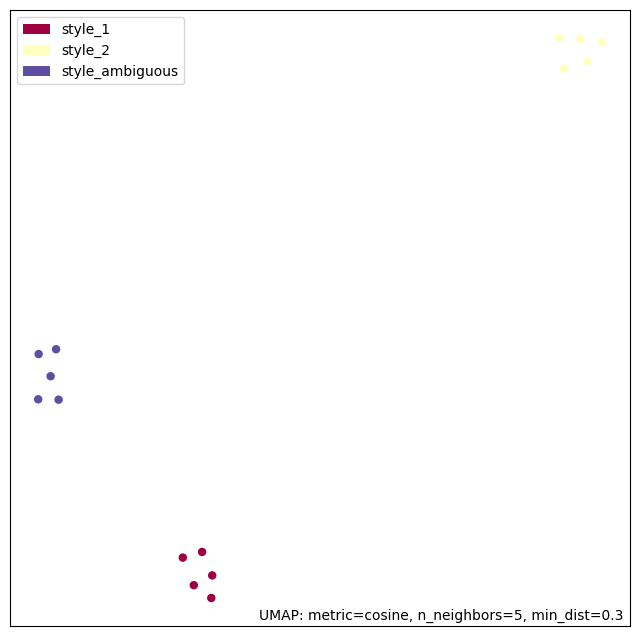

In [167]:
embedding = mapper.fit_transform(all_embeddings.cpu().detach().numpy())
umap.plot.points(mapper, labels=labels)

In [168]:
# similarity to dissimilar style
cosine_similarity = torch.nn.functional.cosine_similarity(style_1_embeddings, style_2_embeddings)
cosine_similarity

tensor([0.2175, 0.1099, 0.0636, 0.0690, 0.1376], device='cuda:0')

In [169]:
# similarity to similar ambiguous but similar style
cosine_similarity = torch.nn.functional.cosine_similarity(style_1_embeddings, style_ambiguous_embeddings)
cosine_similarity

tensor([0.5575, 0.4632, 0.3314, 0.3356, 0.4225], device='cuda:0')

In [170]:
# similarity to itself
cosine_similarity = torch.nn.functional.cosine_similarity(style_1_embeddings, style_1_embeddings.flip(dims=(0,)))
cosine_similarity

tensor([0.8729, 0.9363, 1.0000, 0.9363, 0.8729], device='cuda:0')

In [21]:
s = style_ambiguous[0]

mask_token = tokenizer.mask_token

tokens = tokenizer.tokenize(s)


In [22]:
tokens

['This', 'Ġis', 'Ġthe', 'Ġfirst', 'Ġsentence', '!']